In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil


# 1.Data Cleaning and Feature Engineering

## 1.1 Importing all the modules used in the project

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

* https://ucladatares.medium.com/the-success-of-movies-at-the-oscars-box-office-and-reviews-e33e5059ea40
* https://www.stat.cmu.edu/capstoneresearch/fall2022/315files_f22/team24.html

## 1.2. Import Dataset

In [ ]:
df = pd.read_csv("data/movies.csv")

In [ ]:
df.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


In [ ]:
movies_metadata_df = df.copy()

In [ ]:
movies_metadata_df.shape

(7668, 15)

## 1.3. Classic data cleaning steps

**Xóa missing values**

In [ ]:
missing_value_percent = movies_metadata_df.isnull().sum() / len(movies_metadata_df) * 100

# Print the results
print(missing_value_percent)

name         0.000000
rating       1.004173
genre        0.000000
year         0.000000
released     0.026082
score        0.039124
votes        0.039124
director     0.000000
writer       0.039124
star         0.013041
country      0.039124
budget      28.312467
gross        2.464789
company      0.221701
runtime      0.052165
dtype: float64


In [ ]:
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


Xử lí lại việc tách date ra theo tháng

In [ ]:
# Extracting 'month' from 'released'
movies_metadata_df['month'] = movies_metadata_df['released'].apply(lambda x: x.split()[0] if isinstance(x, str) else np.nan)
valid_months = ['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January']

movies_metadata_df['month'] = movies_metadata_df['released'].apply(lambda x: x.split()[0] if isinstance(x, str) and x.split()[0] in valid_months else np.nan)

# Handling missing values by filling them with appropriate placeholders or zeros
movies_metadata_df["genre"].fillna('Unknown', inplace=True)
movies_metadata_df['country'].fillna('Unknown', inplace=True)
movies_metadata_df['name'].fillna('Unknown', inplace=True)
movies_metadata_df['rating'].fillna('Unknown', inplace=True)
movies_metadata_df['writer'].fillna('Unknown', inplace=True)
movies_metadata_df['star'].fillna('Unknown', inplace=True)
movies_metadata_df['company'].fillna('Unknown', inplace=True)
movies_metadata_df['month'].fillna('Unknown', inplace = True)
movies_metadata_df[['score','votes','budget', 'gross','runtime', 'year']] = movies_metadata_df[['score','votes','budget', 'gross', 'runtime', 'year']].fillna(0)

# Previewing the cleaned dataset
movies_metadata_df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,month
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0,June
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0,July
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0,June
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0,July
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0,July


**Delete duplicate**

In [ ]:
num_duplicates = movies_metadata_df.duplicated().sum()

# Calculate the percentage of duplicates
percent_duplicates = (num_duplicates / len(movies_metadata_df)) * 100

# Print the results
print("Percentage of Duplicate Rows:", percent_duplicates, "%")

Percentage of Duplicate Rows: 0.0 %


In [ ]:
total_rows = len(movies_metadata_df)

# Filter rows where revenue is equal to 0
zero_revenue_rows = movies_metadata_df[movies_metadata_df['budget'] == 0]

# Count the number of rows where revenue is equal to 0
zero_revenue_count = len(zero_revenue_rows)

# Calculate the percentage
percentage_zero_revenue = (zero_revenue_count / total_rows) * 100

print("Percentage of budget equal to 0:", percentage_zero_revenue)

Percentage of budget equal to 0: 28.31246739697444


## 1.4 change datatype for budget and revenue

In [ ]:
# Delete extra characters
movies_metadata_df.columns = movies_metadata_df.columns.str.replace('[', '')
movies_metadata_df.columns = movies_metadata_df.columns.str.replace(']', '')
movies_metadata_df.columns = movies_metadata_df.columns.str.replace('<', '')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5936\433311320.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_metadata_df.columns = movies_metadata_df.columns.str.replace('[', '')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5936\433311320.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies_metadata_df.columns = movies_metadata_df.columns.str.replace(']', '')


In [ ]:
# Setting 'name' as the index
movies_metadata_df.set_index('name', inplace=True)
# Không lấy cột name

## 1.5 Feature engineering

**successful**: revenue >2*budget and (0.6ximdb score+ audience socrex0.4) > mean của (imdb score+ vote_count) cả toàn bộ data

In [ ]:
movies_metadata_df['budget'] = pd.to_numeric(movies_metadata_df['budget'], errors='coerce')
def is_film_successful(row):
    revenue_condition = row['gross'] >= 2 * row['budget']
    score_condition = row['score'] > 0.5
    return revenue_condition and score_condition

movies_metadata_df['successful'] = movies_metadata_df.apply(is_film_successful, axis=1)

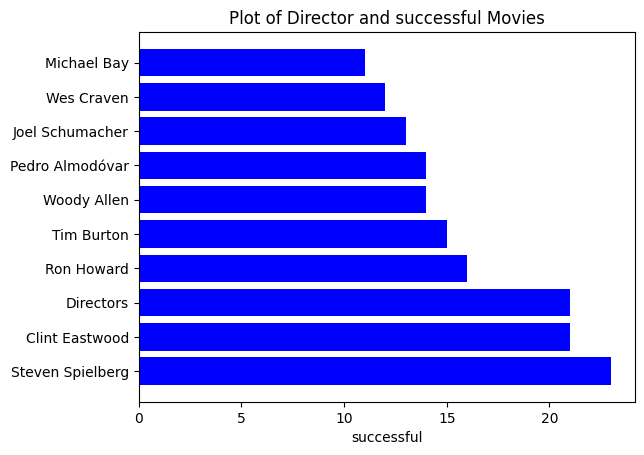

In [ ]:
# Group by 'Director' and sum 'Successful'
grouped_df = movies_metadata_df.groupby('director')['successful'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('successful', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['successful'], color='blue')
plt.xlabel('successful')
plt.title('Plot of Director and successful Movies')
plt.show()

In [ ]:
def is_condition_1(row):
    revenue_condition = row['gross'] >= 2 * row['budget']
    return revenue_condition

movies_metadata_df['condition_1'] = movies_metadata_df.apply(is_condition_1, axis=1)

In [ ]:
movies_metadata_df['successful'] = movies_metadata_df['successful'].astype(int)

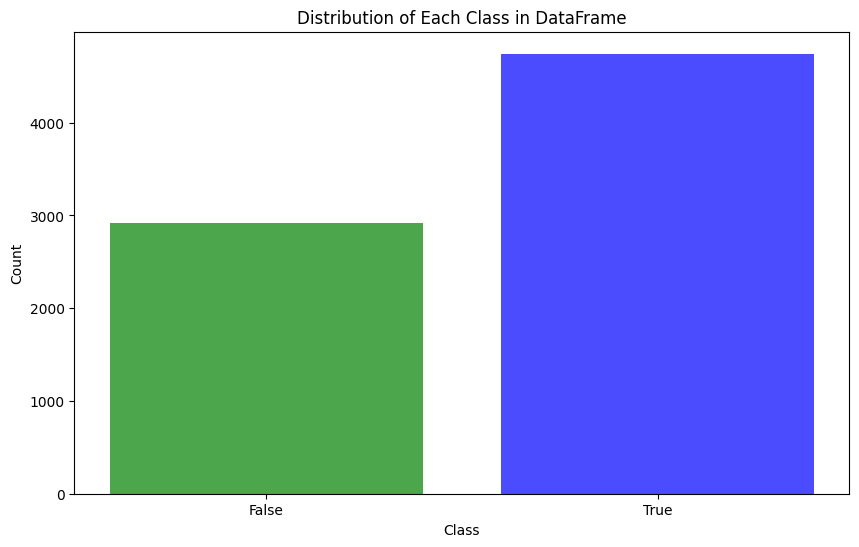

In [ ]:
class_counts = movies_metadata_df['successful'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(class_counts.index, class_counts.values, color=['b', 'g'], alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Each Class in DataFrame')
plt.xticks(ticks=[0,1], labels=['False', 'True'])
plt.show()


# 2. EDA (Exploratory Data Analysis)



## 2.1. Distribution of Numerical Features
   - Distribution of `budget`, `gross`, `runtime`, and `votes`.

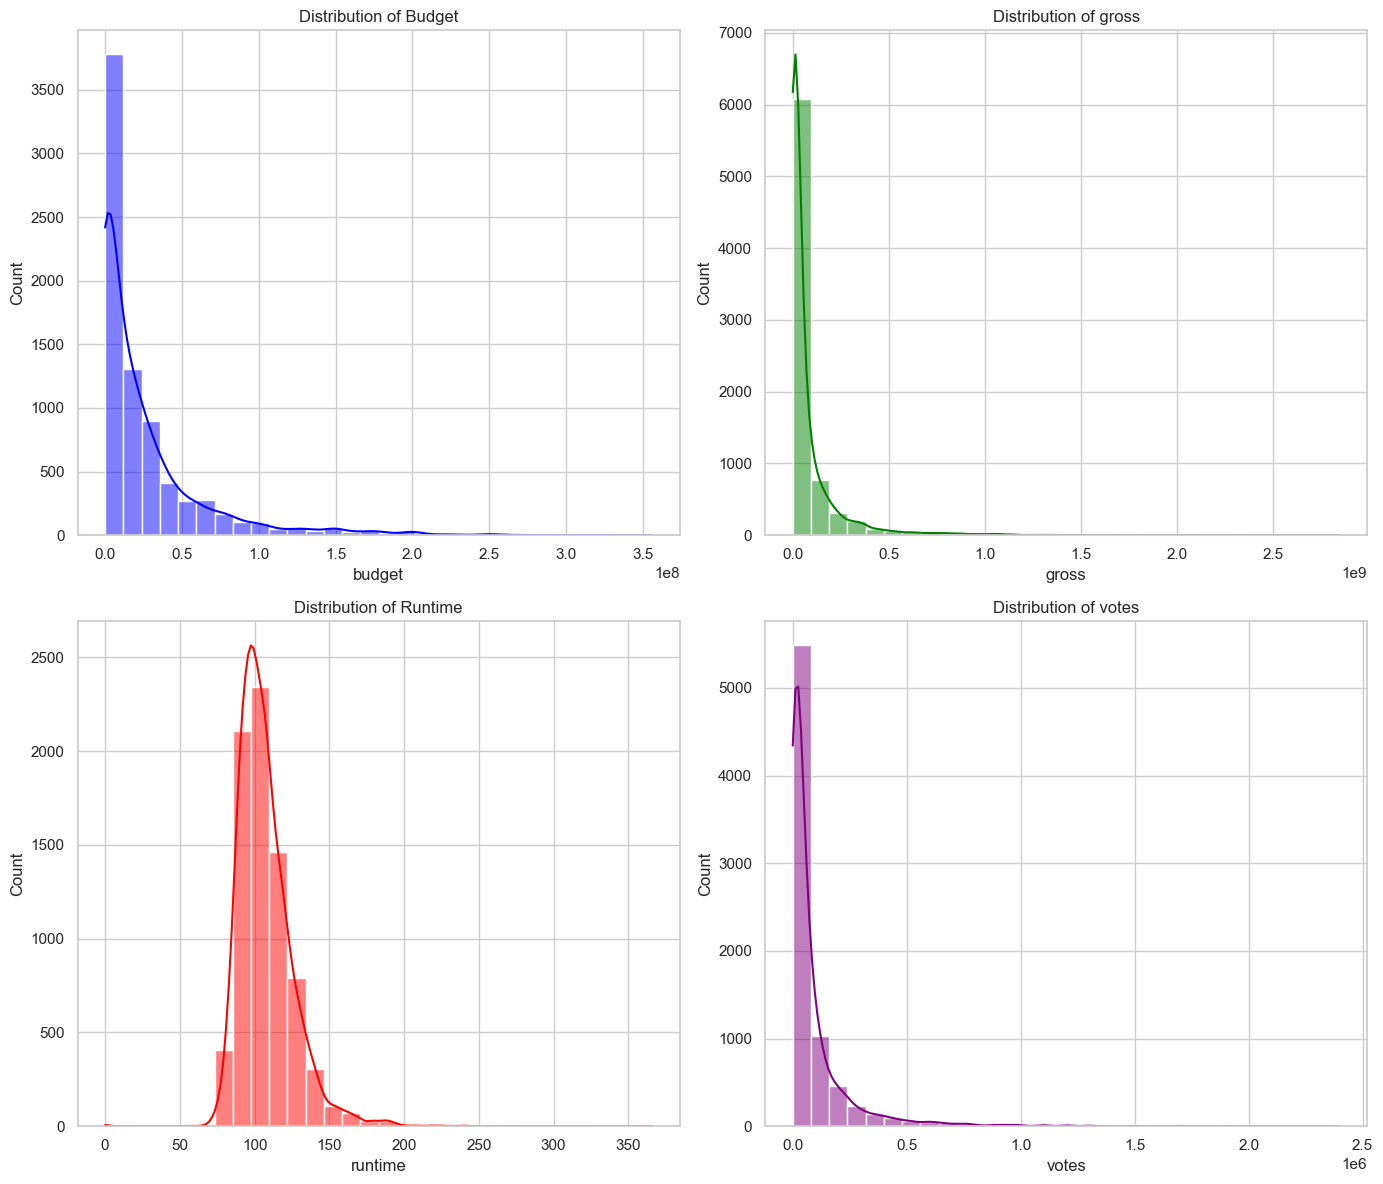

In [ ]:
# Setting the style of seaborn
sns.set(style="whitegrid")

# 1. Distribution of Numerical Features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
sns.histplot(data=movies_metadata_df, x='budget', bins=30, ax=axes[0, 0], kde=True, color='blue')
axes[0, 0].set_title('Distribution of Budget')
sns.histplot(data=movies_metadata_df, x='gross', bins=30, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('Distribution of gross')
sns.histplot(data=movies_metadata_df, x='runtime', bins=30, ax=axes[1, 0], kde=True, color='red')
axes[1, 0].set_title('Distribution of Runtime')
sns.histplot(data=movies_metadata_df, x='votes', bins=30, ax=axes[1, 1], kde=True, color='purple')
axes[1, 1].set_title('Distribution of votes')
plt.tight_layout()
plt.show()


The histograms above provide insights into the distribution of `budget`, `gross`, `runtime`, and `votes`

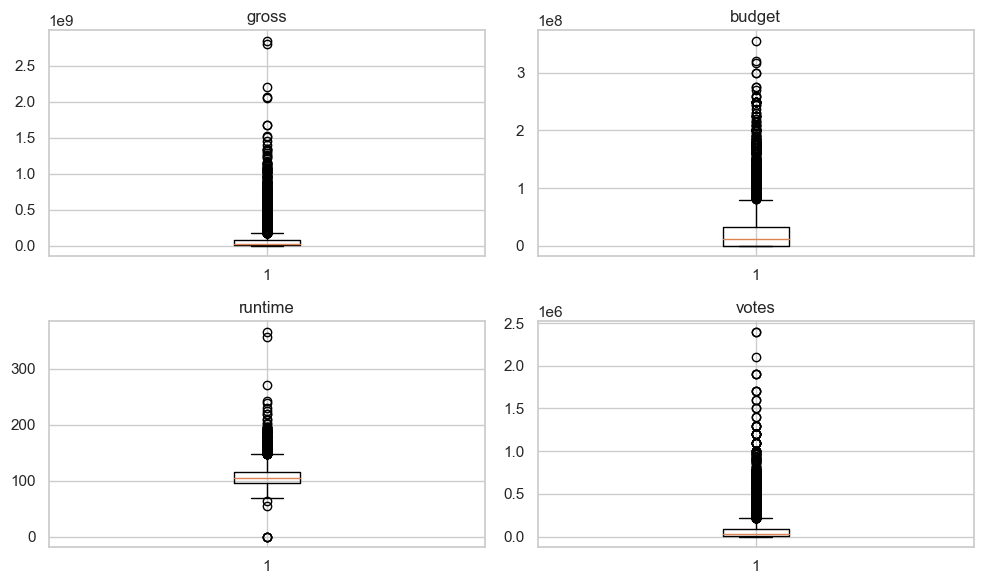

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

columns_to_plot = ['gross', 'budget', 'runtime', 'votes']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Plot each column in a separate boxplot
for i, col in enumerate(columns_to_plot):
    row = i // 2  # Calculate row index
    col_index = i % 2  # Calculate column index
    axes[row, col_index].boxplot(movies_metadata_df[col])
    axes[row, col_index].set_title(col)

plt.tight_layout()
plt.show()


## 2.2. Categorical Feature Analysis

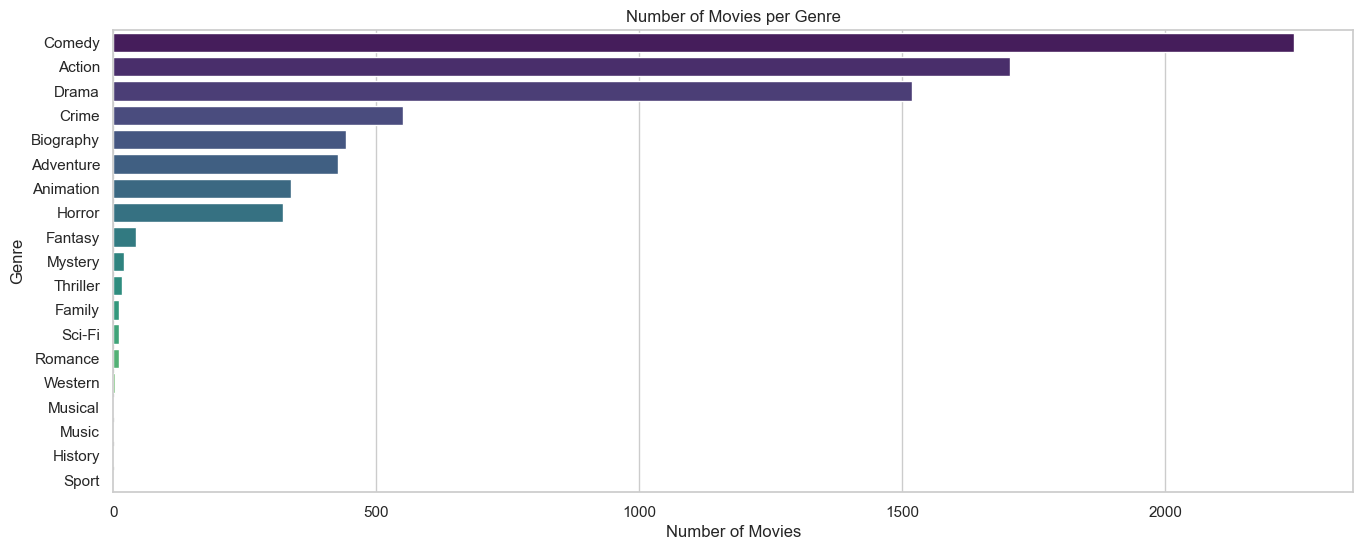

In [ ]:
# Number of Movies per Primary Genre
plt.figure(figsize=(16, 6))
sns.countplot(data=movies_metadata_df, y='genre', order=movies_metadata_df['genre'].value_counts().index, palette="viridis")
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

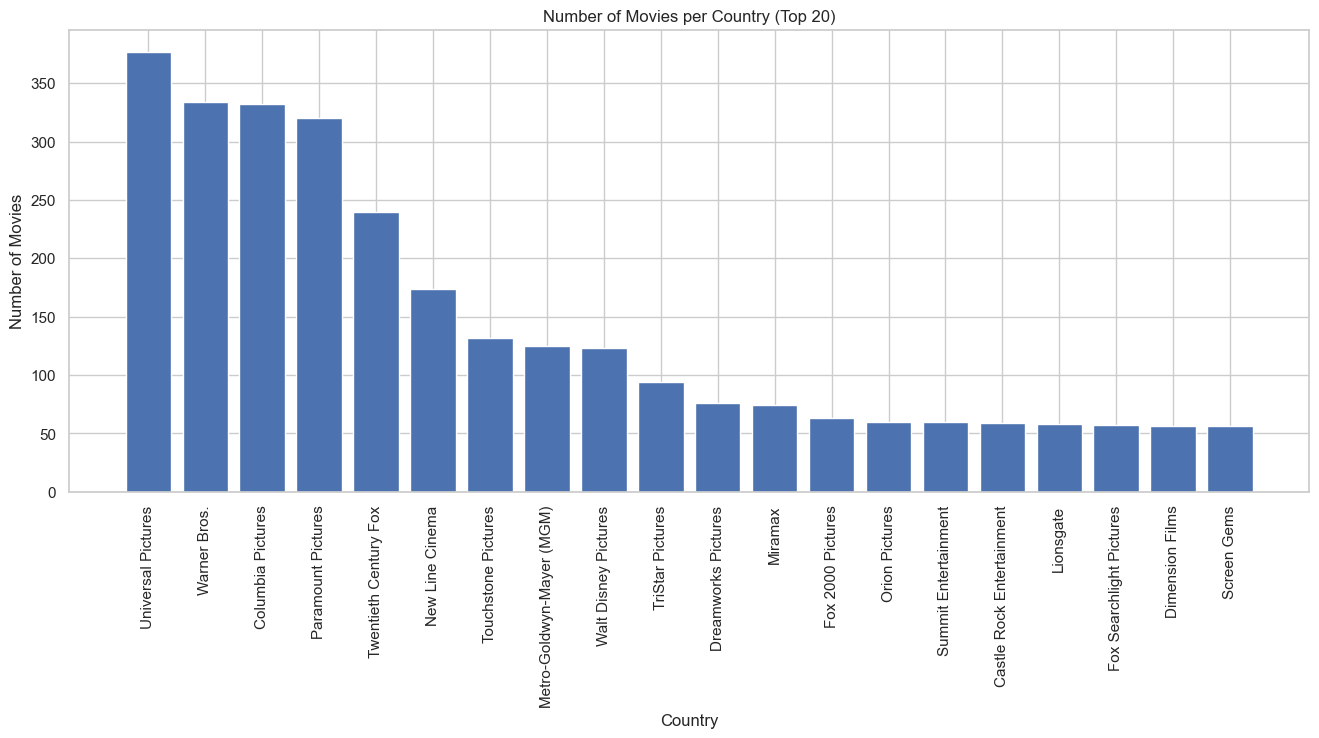

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

top_20_counts = movies_metadata_df['company'].value_counts().head(20)

plt.figure(figsize=(16, 6))
plt.bar(top_20_counts.index, top_20_counts.values)
plt.title('Number of Movies per Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90)
plt.show()


## 2.3. Time-based Analysis

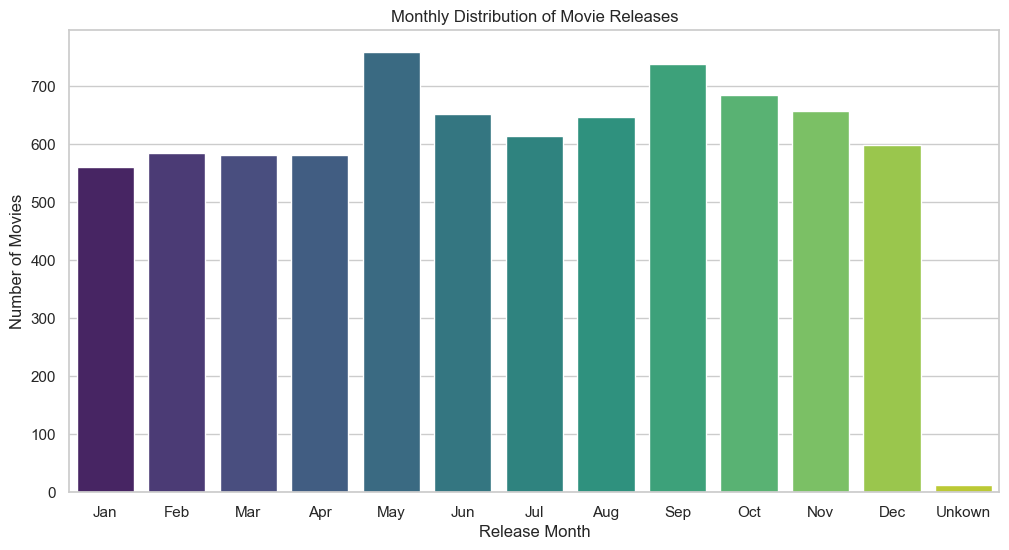

In [ ]:
# Monthly Distribution of Movie Releases
plt.figure(figsize=(12, 6))
sns.countplot(data=movies_metadata_df, x='month', palette="viridis")
plt.title('Monthly Distribution of Movie Releases')
plt.xlabel('Release Month')
plt.ylabel('Number of Movies')
plt.xticks(ticks=range(13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec','Unkown'])
plt.show()


## 2.4. Correlation Analysis
   - Correlation between numerical features.

In [ ]:
def get_pearson_corr_matrix(df: pd.DataFrame) -> pd.DataFrame:
    ### BEGIN SOLUTION
    correlation_matrix = df.corr(method='pearson')
    return correlation_matrix
    ### END SOLUTION
    pass

In [ ]:
df = movies_metadata_df[['year', 'score', 'votes', 'budget', 'gross', 'runtime']]

In [ ]:
# Tạo correlation matrix từ hàm đã viết
corr_matrix = get_pearson_corr_matrix(df)

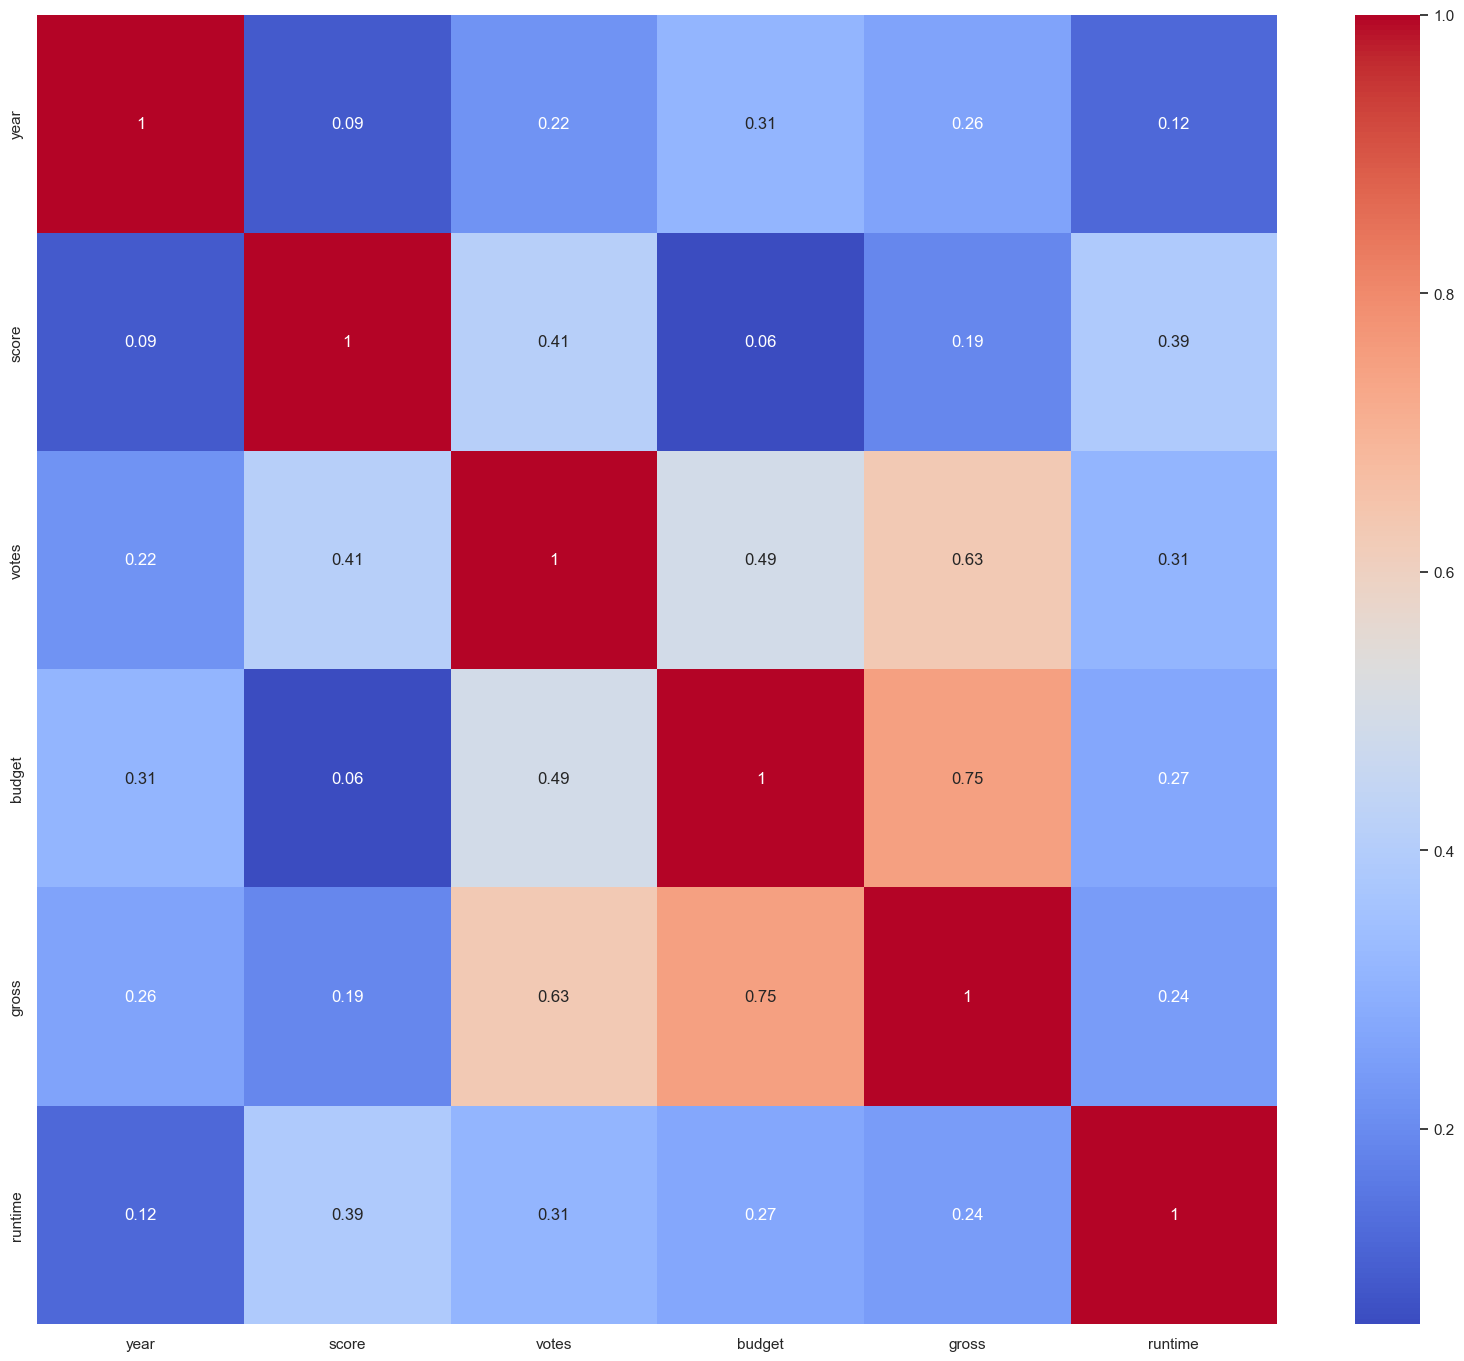

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 17))
sns.heatmap(corr_matrix.round(2), annot=True, cmap='coolwarm')
plt.show()

## 2.5. Analysis the impact of features to successful movie (6 questions)


### 2.5.1 budget and revenue

**Question: Does a higher budget generally lead to higher revenue?**

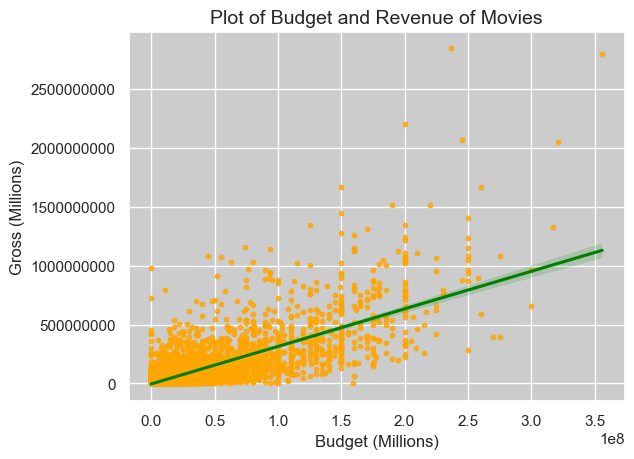

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})  # Grey background

# Create scatter plot with regression line
sns.regplot(x='budget', y='gross', data=df,
            scatter_kws={'s': 10, 'color': 'orange'},
            line_kws={'color': 'green'})

# Add labels and title
plt.xlabel('Budget (Millions)', fontsize=12)
plt.ylabel('Gross (Millions)', fontsize=12)
plt.title('Plot of Budget and Revenue of Movies', fontsize=14)

# Format y-axis to display numbers in millions (e.g., 200 million)
# You'll need to modify this based on your data's scale
plt.ticklabel_format(style='plain', axis='y')

# Display the plot
plt.show()


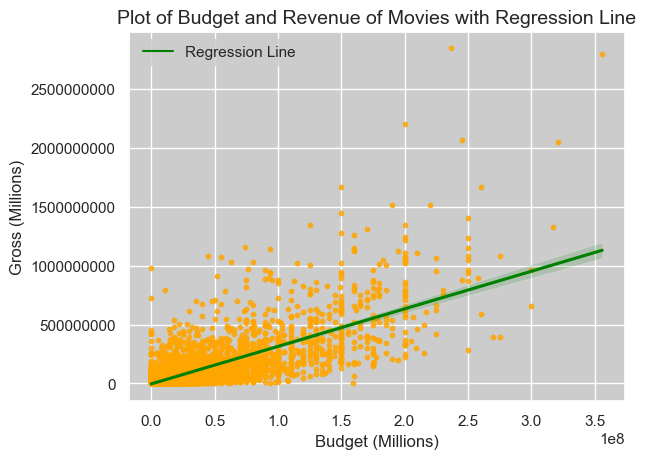

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(movies_metadata_df[['budget']], movies_metadata_df['gross'])

# Get coefficients
m = model.coef_[0]  # Slope (coefficient of budget)
b = model.intercept_  # Y-intercept

# Predict gross revenue based on different budgets
budget_range = range(0, 110, 10)  # Range of budgets to predict for
predicted_gross = [m * budget + b for budget in budget_range]

# Create scatter plot with regression line
sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})  # Grey background

sns.regplot(x='budget', y='gross', data=df,
            scatter_kws={'s': 10, 'color': 'orange'},
            line_kws={'color': 'green'})

# Plot the regression line
plt.plot(budget_range, predicted_gross, color='green', label='Regression Line')

# Add labels and title
plt.xlabel('Budget (Millions)', fontsize=12)
plt.ylabel('Gross (Millions)', fontsize=12)
plt.title('Plot of Budget and Revenue of Movies with Regression Line', fontsize=14)

# Format y-axis to display numbers in millions (e.g., 200 million)
# You'll need to modify this based on your data's scale
plt.ticklabel_format(style='plain', axis='y')

# Add legend
plt.legend()

# Display the plot
plt.show()

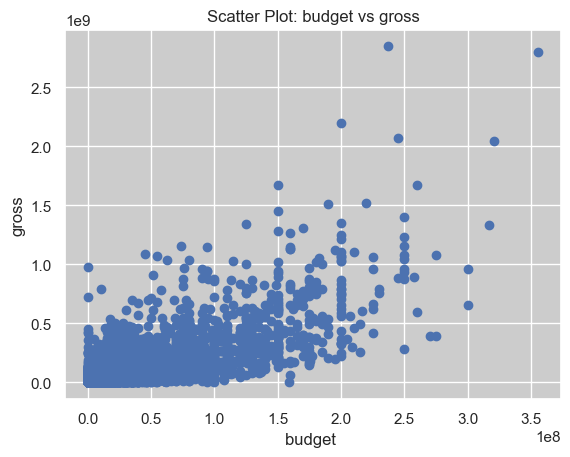

In [ ]:
plt.scatter(movies_metadata_df['budget'], movies_metadata_df['gross'])
plt.xlabel('budget ')
plt.ylabel('gross')
plt.title('Scatter Plot: budget vs gross')
plt.show()

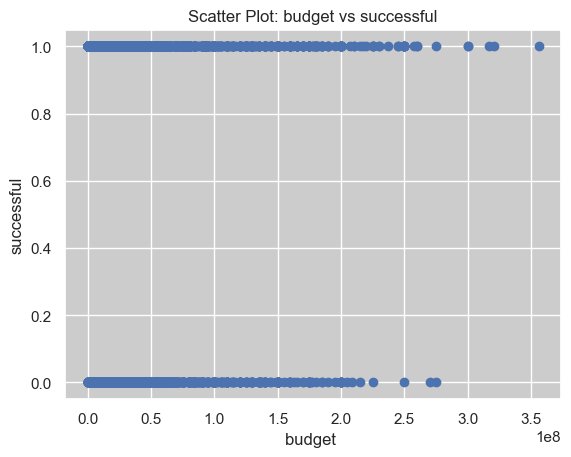

In [ ]:
plt.scatter(movies_metadata_df['budget'], movies_metadata_df['successful'])
plt.xlabel('budget ')
plt.ylabel('successful')
plt.title('Scatter Plot: budget vs successful')
plt.show()

=> Number of budget do not affect successful label

**=> Không bàn cãi, budget vs revenue tuyến tính với nhau**

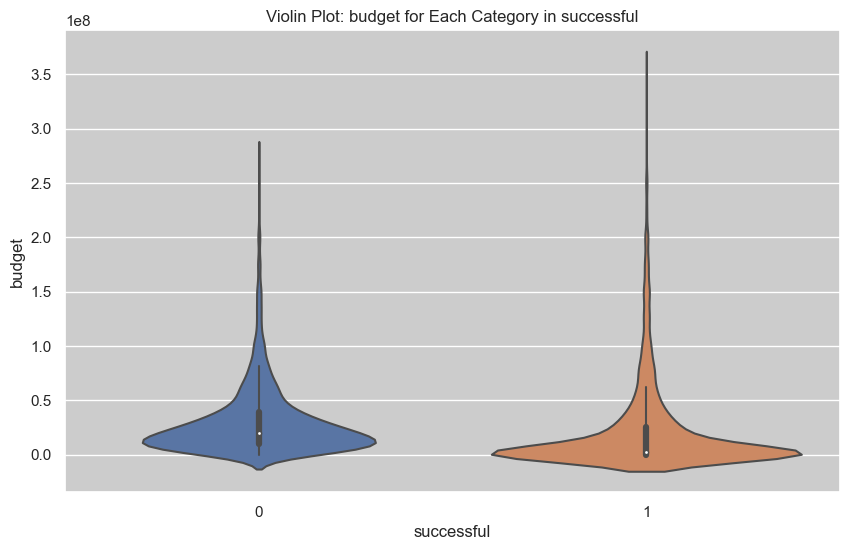

In [ ]:
plt.figure(figsize=(10,6))
sns.violinplot(x='successful', y='budget', data=movies_metadata_df)
plt.title('Violin Plot: budget for Each Category in successful')
plt.show()


**=> Get no insight**

### 2.5.2 gross vs director

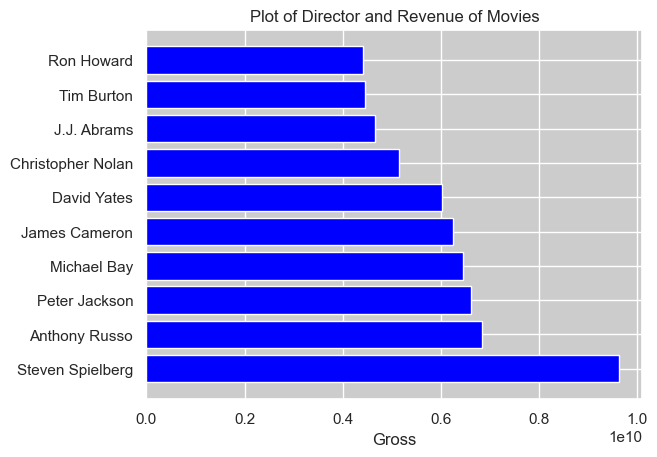

In [ ]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('director')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Director and Revenue of Movies')
plt.show()

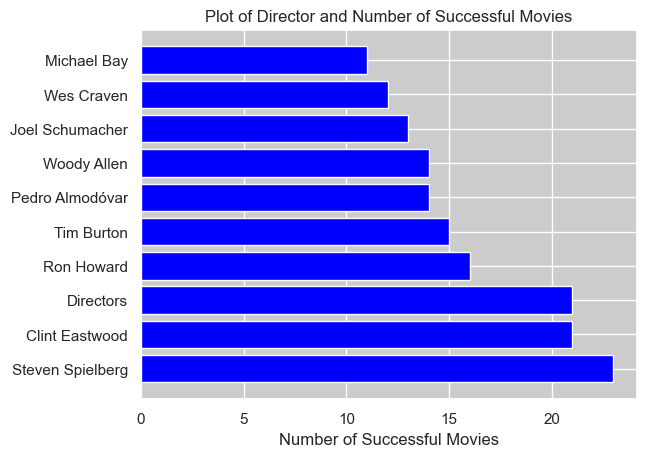

In [ ]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('director').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Director and Number of Successful Movies')
plt.show()


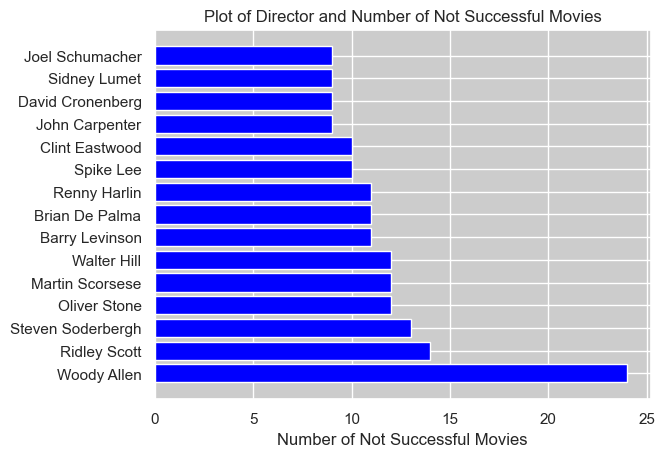

In [ ]:
# Group by 'director' and count 'not successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 0].groupby('director').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['count'], color='blue')
plt.xlabel('Number of Not Successful Movies')
plt.title('Plot of Director and Number of Not Successful Movies')
plt.show()


### 2.5.3 gross vs company

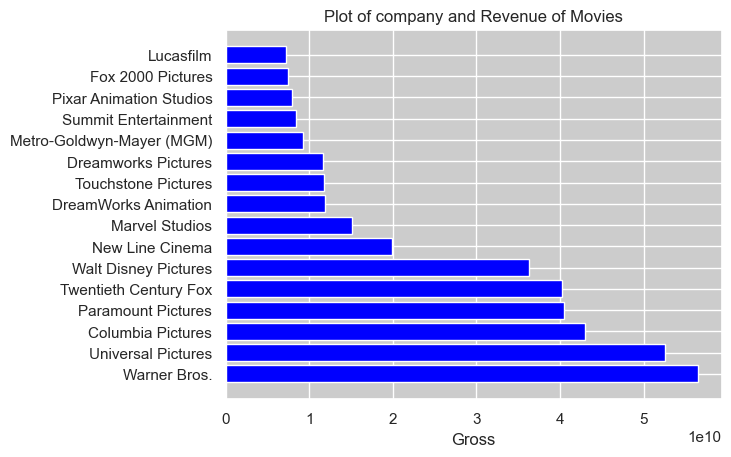

In [ ]:
# Group by 'Company' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('company')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(16)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of company and Revenue of Movies')
plt.show()

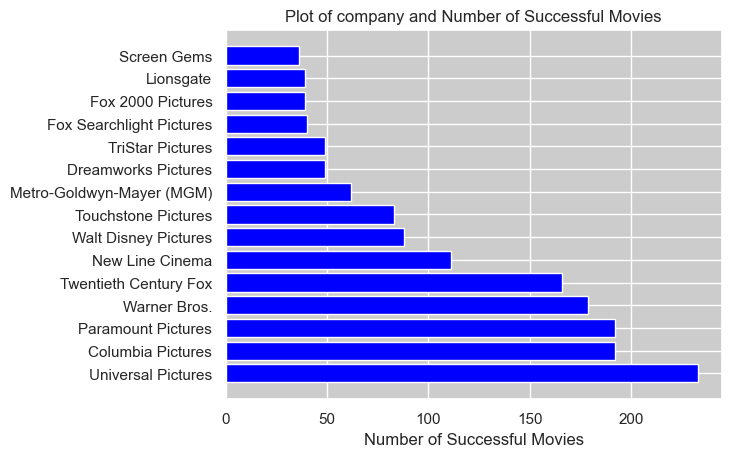

In [ ]:
# Group by 'Company' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('company').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of company and Number of Successful Movies')
plt.show()


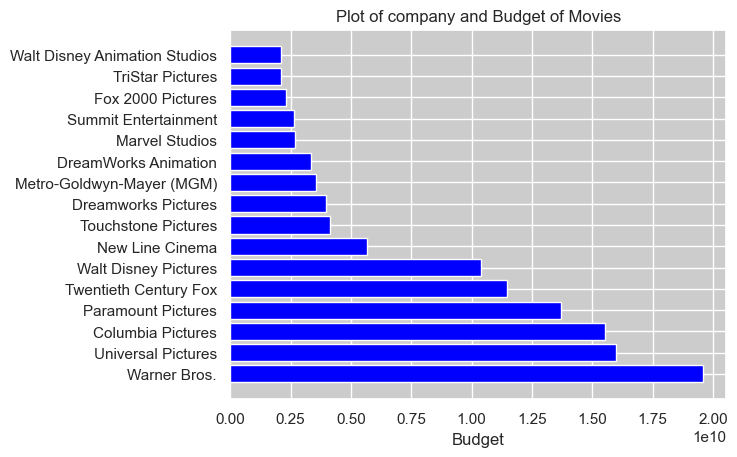

In [ ]:
# Group by 'Company' and sum 'Budget'
grouped_df = movies_metadata_df.groupby('company')['budget'].sum().reset_index()

# Sort the DataFrame by 'Budget' in descending order for better visualization
grouped_df = grouped_df.sort_values('budget', ascending=False).head(16)

# Create a horizontal bar plot
plt.barh(grouped_df['company'], grouped_df['budget'], color='blue')
plt.xlabel('Budget')
plt.title('Plot of company and Budget of Movies')
plt.show()

### 2.5.4 Gross vs IMDB Score vs user votes

**Question: How imdb score affect gross?**

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


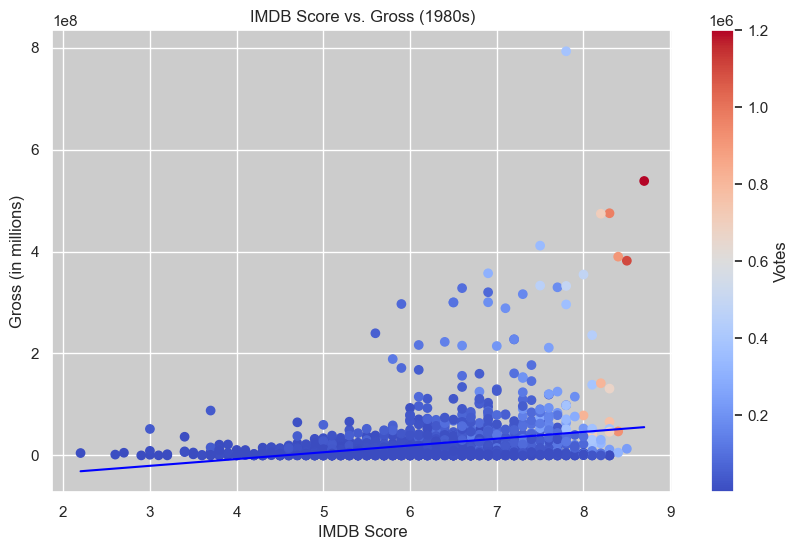

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Filter the DataFrame to only include movies from the 1980s
df = movies_metadata_df[(movies_metadata_df['year'] >= 1980) & (movies_metadata_df['year'] < 1990)]

# Create a scatter plot with a color gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['score'], df['gross'], c=df['votes'], cmap='coolwarm')
plt.colorbar(scatter, label='Votes')
plt.xlabel('IMDB Score')
plt.ylabel('Gross (in millions)')

# Fit a line of best fit
model = LinearRegression()
model.fit(df[['score']], df['gross'])
x_range = np.linspace(df['score'].min(), df['score'].max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), color='blue')

plt.title('IMDB Score vs. Gross (1980s)')
plt.show()


**=> Having a good score doesn’t equate to having a high grossing movie. Rather it shows the potential of a movie to reach a high gross.**

**Question: Relationship between IMDB Score and User Vote?**

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5936\1071924229.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=movies_metadata_df, x='score', y='votes' , palette='coolwarm')


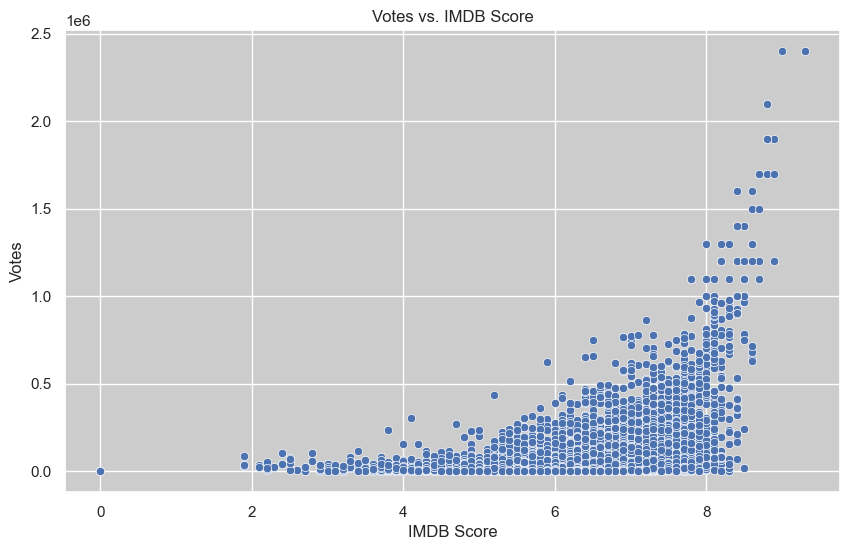

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot with different colors for each content rating
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_metadata_df, x='score', y='votes' , palette='coolwarm')
plt.xlabel('IMDB Score')
plt.ylabel('Votes')
plt.title('Votes vs. IMDB Score')
plt.show()


**=> IMDB Score vs User Score is relatively linear**

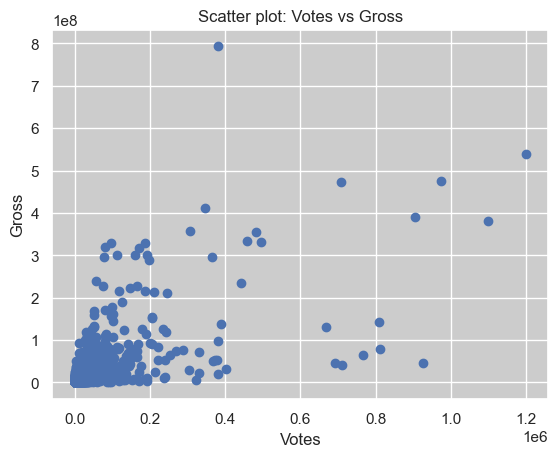

In [ ]:
plt.scatter(df['votes'], df['gross'])

plt.title('Scatter plot: Votes vs Gross')
plt.xlabel('Votes')
plt.ylabel('Gross')
plt.show()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


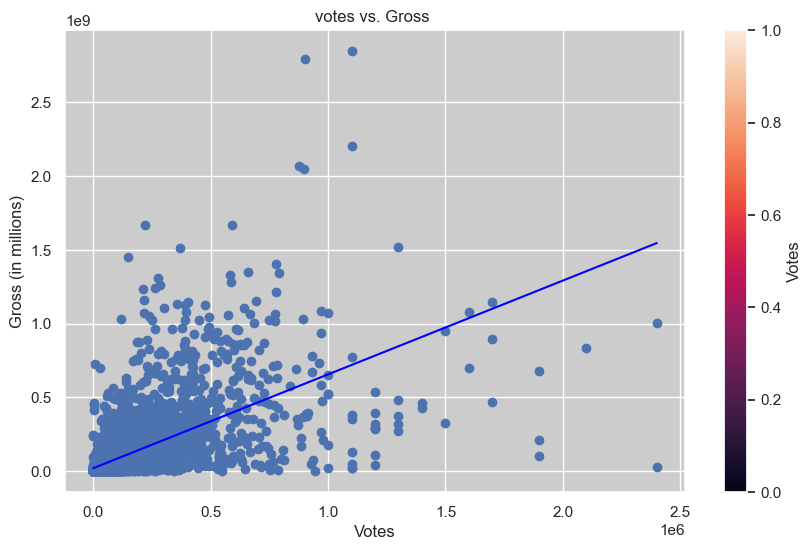

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

df = movies_metadata_df.copy()

# Create a scatter plot with a color gradient
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['votes'], df['gross'])
plt.colorbar(scatter, label='Votes')
plt.xlabel('Votes')
plt.ylabel('Gross (in millions)')

# Fit a line of best fit
model = LinearRegression()
model.fit(df[['votes']], df['gross'])
x_range = np.linspace(df['votes'].min(), df['votes'].max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), color='blue')

plt.title('votes vs. Gross ')
plt.show()

**=> Gross vs Votes relatively linear**

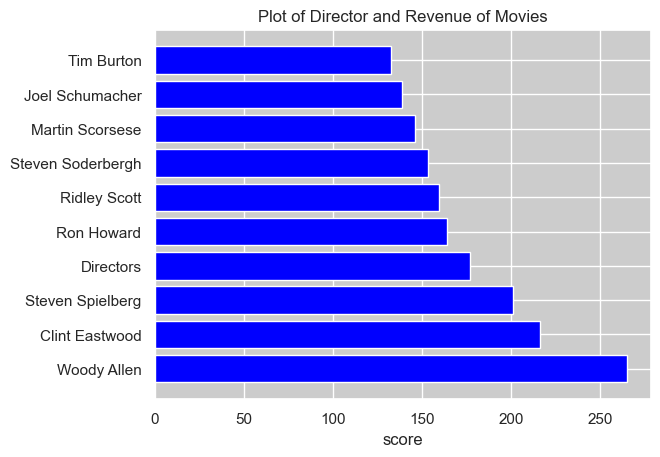

In [ ]:
grouped_df = movies_metadata_df.groupby('director')['score'].sum().reset_index()
grouped_df = grouped_df.sort_values('score', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['score'], color='blue')
plt.xlabel('score')
plt.title('Plot of Director and Revenue of Movies')
plt.show()

### 2.5.5 Gross vs Critics

In [ ]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['rating'].str.upper() != 'X']

**Question: How critics affect revenue?**

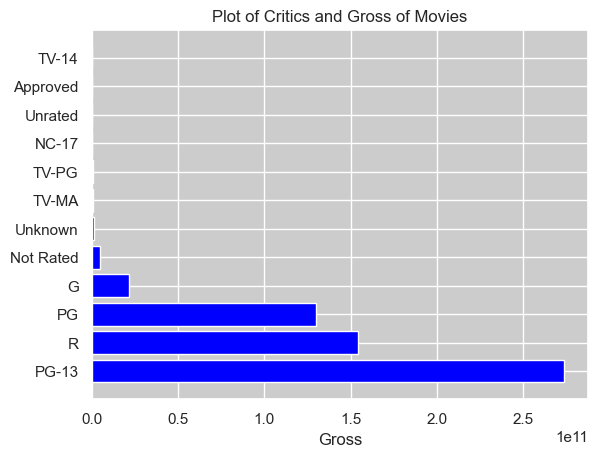

In [ ]:
grouped_df = movies_metadata_df.groupby('rating')['gross'].sum().reset_index()
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Critics and Gross of Movies')
plt.show()

**gộp lại thành 4 loại**

=> Những bộ phim giới hạn dưới 13 tuổi có doanh thu cao nhất

=> compare vs revenue >2*budget => prove tuyến tính vs score hoặc vote => successful=> ms gộp vào


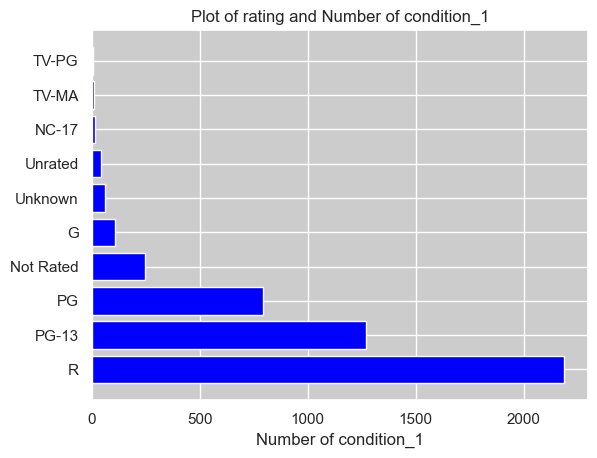

In [ ]:
# Group by 'director' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['condition_1'] == 1].groupby('rating').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['count'], color='blue')
plt.xlabel('Number of condition_1')
plt.title('Plot of rating and Number of condition_1')
plt.show()


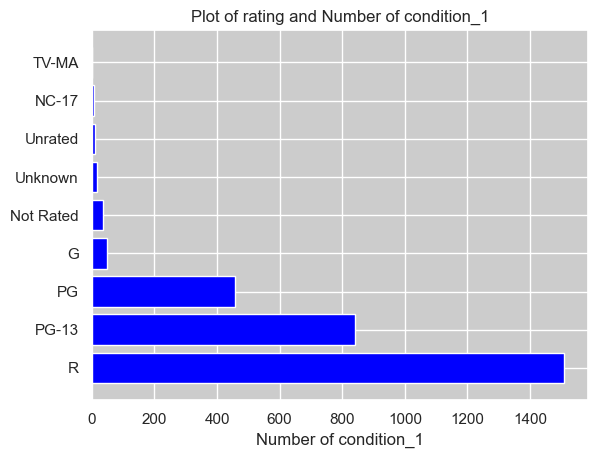

In [ ]:
grouped_df = movies_metadata_df[movies_metadata_df['condition_1'] == 0].groupby('rating').size().reset_index(name='count')
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['rating'], grouped_df['count'], color='blue')
plt.xlabel('Number of condition_1')
plt.title('Plot of rating and Number of condition_1')
plt.show()


=> plot chứng minh revenue > 2*budget và vote và score

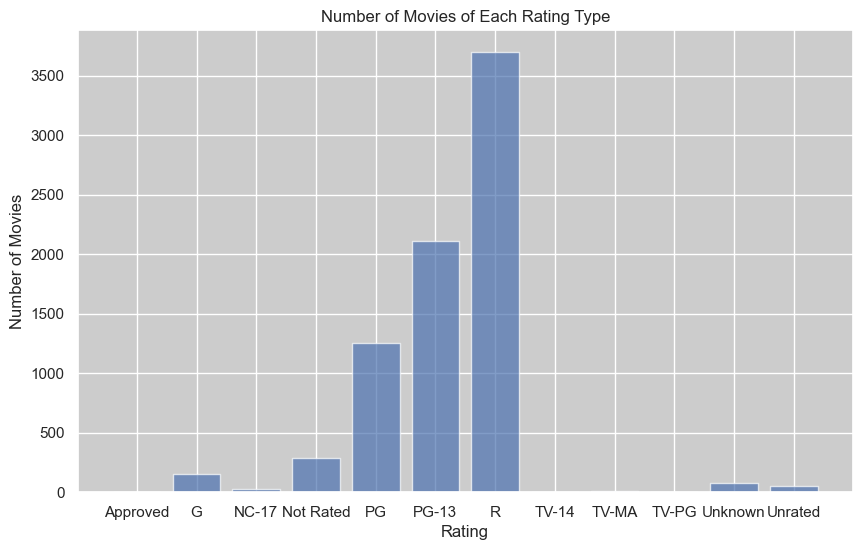

In [ ]:
# Count the number of movies for each rating
rating_counts = movies_metadata_df.groupby('rating')['successful'].count()

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(rating_counts.index, rating_counts.values, color='b', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies of Each Rating Type')
plt.show()

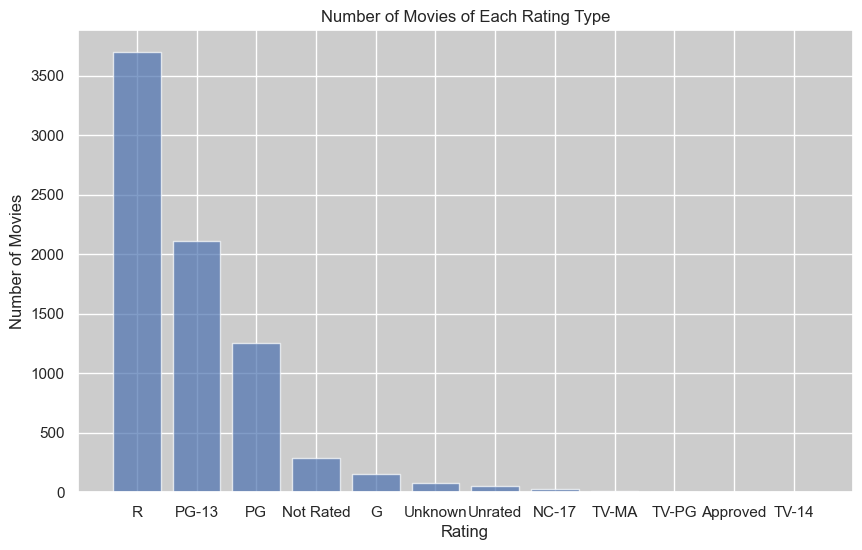

In [ ]:
# Count the number of movies for each rating
rating_counts = movies_metadata_df['rating'].value_counts()

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(rating_counts.index, rating_counts.values, color='b', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies of Each Rating Type')
plt.show()

Nhận thấy, PG-13 có doanh thu cao nhất dù số lượng phim đứng sau R.
Tương tự Not Rated có số lượng phim nhiều hơn nhưng doanh thu thấp hơn.

**=> Như vậy, những critics rating nhất định sẽ có ảnh hưởng tới gross của bộ phim**

### 2.5.6 Genre vs Gross

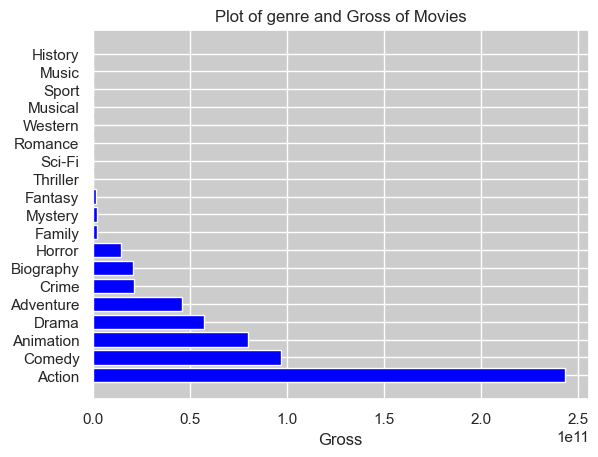

In [ ]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('genre')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['genre'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of genre and Gross of Movies')
plt.show()

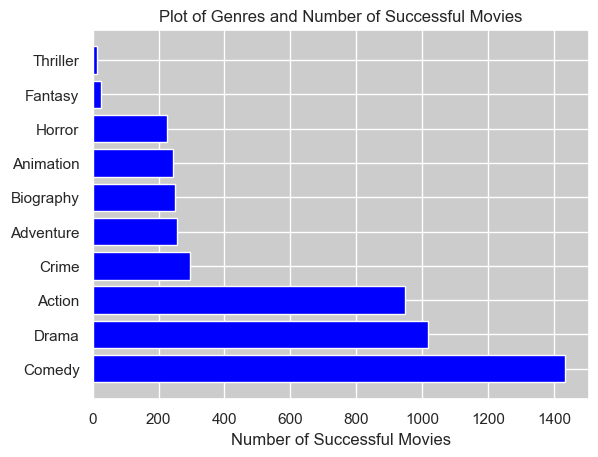

In [ ]:
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('genre').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order and get the top 15
grouped_df = grouped_df.sort_values('count', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['genre'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Genres and Number of Successful Movies')
plt.show()


### 2.5.7 Genre vs year

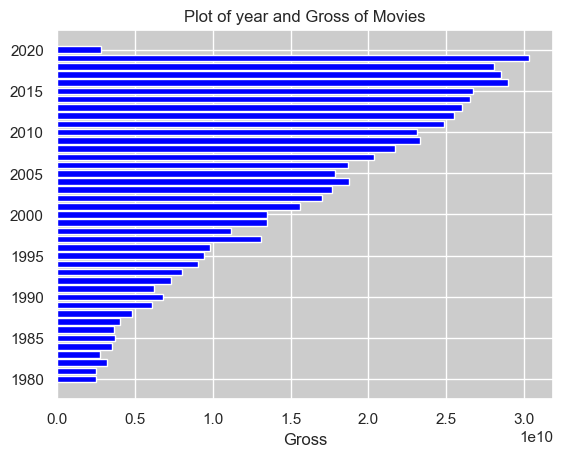

In [ ]:
grouped_df = movies_metadata_df.groupby('year')['gross'].sum().reset_index()
grouped_df = grouped_df.sort_values('gross', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['year'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of year and Gross of Movies')
plt.show()

### 2.5.8 Month vs Gross

In [ ]:
movies_metadata_df['month'].unique()

array(['June', 'July', 'May', 'December', 'October', 'September',
       'February', 'April', 'August', 'March', 'November', 'January',
       'Unknown'], dtype=object)

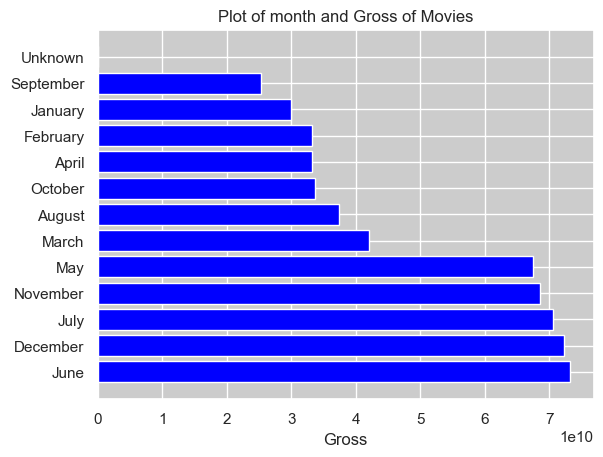

In [ ]:
grouped_df = movies_metadata_df.groupby('month')['gross'].sum().reset_index()
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of month and Gross of Movies')
plt.show()

**Whether month release affect successful label?**

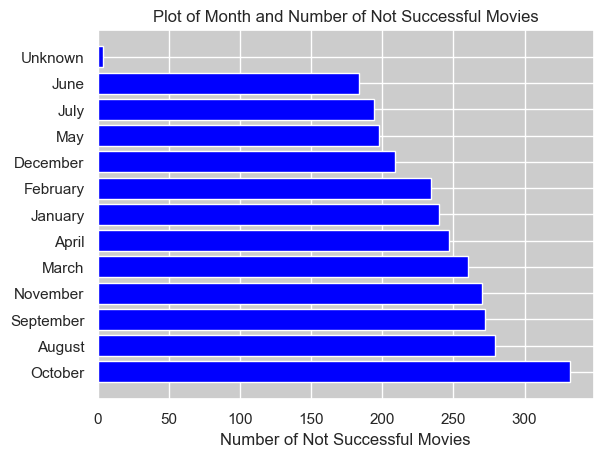

In [ ]:
# Group by 'month' and count 'Not successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 0].groupby('month').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order for better visualization
grouped_df = grouped_df.sort_values('count', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['count'], color='blue')
plt.xlabel('Number of Not Successful Movies')
plt.title('Plot of Month and Number of Not Successful Movies')
plt.show()

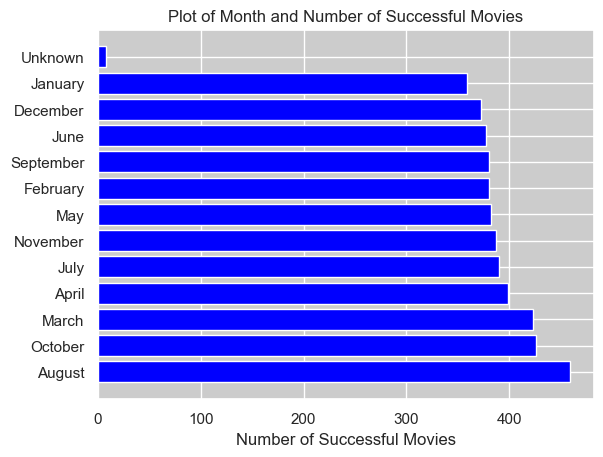

In [ ]:
# Group by 'month' and count 'successful' movies
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('month').size().reset_index(name='count')

# Sort the DataFrame by 'count' in descending order for better visualization
grouped_df = grouped_df.sort_values('count', ascending=False)

# Create a horizontal bar plot
plt.barh(grouped_df['month'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of Month and Number of Successful Movies')
plt.show()

### 2.5.9 writer vs gross

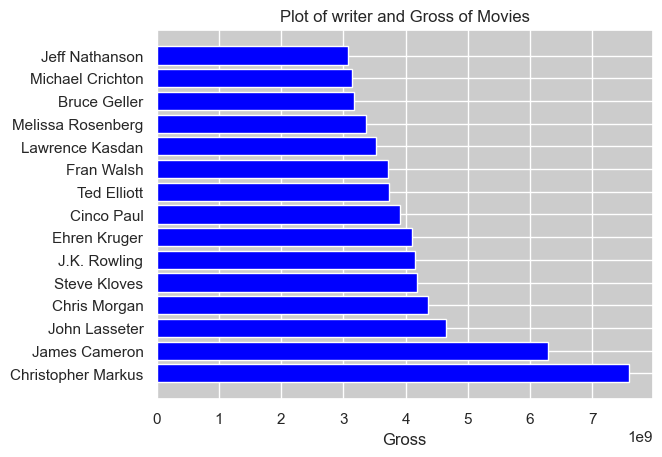

In [ ]:
grouped_df = movies_metadata_df.groupby('writer')['gross'].sum().reset_index()
grouped_df = grouped_df.sort_values('gross', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['writer'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of writer and Gross of Movies')
plt.show()

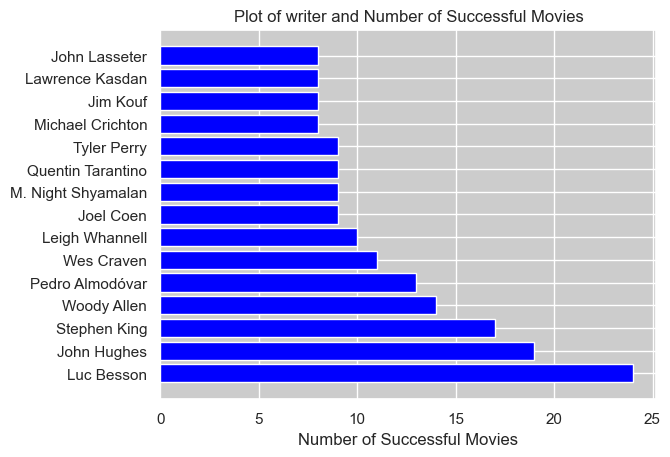

In [ ]:
grouped_df = movies_metadata_df[movies_metadata_df['successful'] == 1].groupby('writer').size().reset_index(name='count')
grouped_df = grouped_df.sort_values('count', ascending=False).head(15)

# Create a horizontal bar plot
plt.barh(grouped_df['writer'], grouped_df['count'], color='blue')
plt.xlabel('Number of Successful Movies')
plt.title('Plot of writer and Number of Successful Movies')
plt.show()


### 2.5.10 main actor/actress vs gross

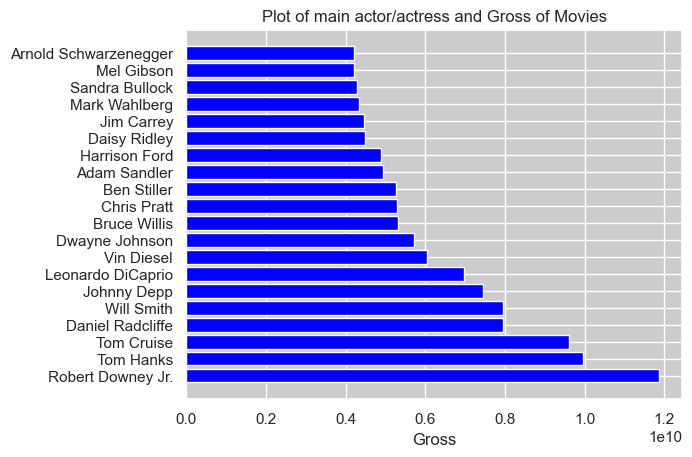

In [ ]:
grouped_df = movies_metadata_df.groupby('star')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['star'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of main actor/actress and Gross of Movies')
plt.show()

### 2.5.11 country vs gross

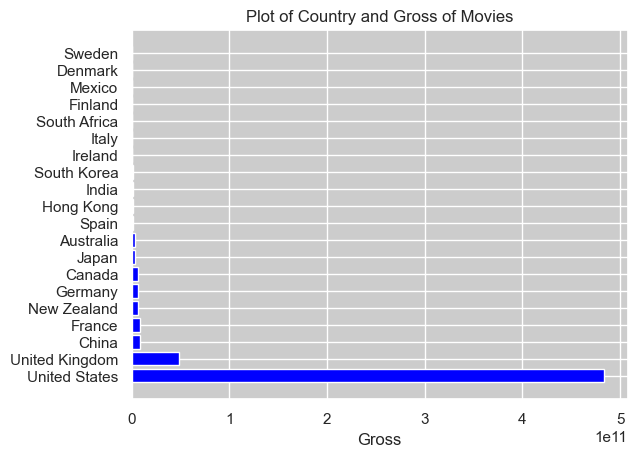

In [ ]:
grouped_df = movies_metadata_df.groupby('country')['gross'].sum().reset_index()
grouped_df = grouped_df.sort_values('gross', ascending=False).head(20)

# Create a horizontal bar plot
plt.barh(grouped_df['country'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Country and Gross of Movies')
plt.show()

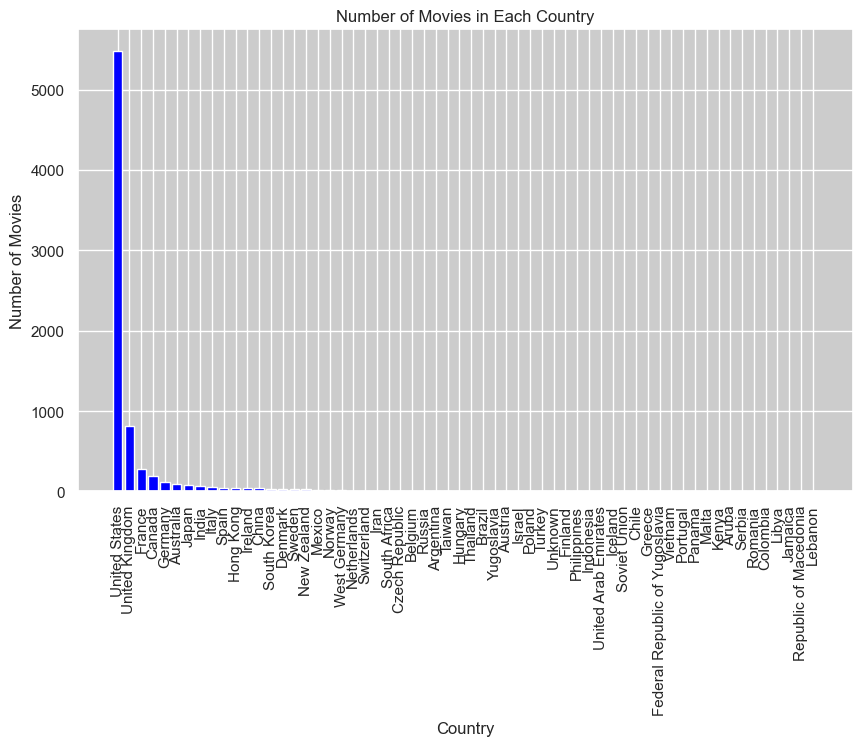

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of movies in each country
country_counts = movies_metadata_df['country'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(country_counts.index, country_counts.values, color='blue')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Number of Movies')
plt.title('Number of Movies in Each Country')
plt.show()


### 2.5.12 Runtime vs Gross

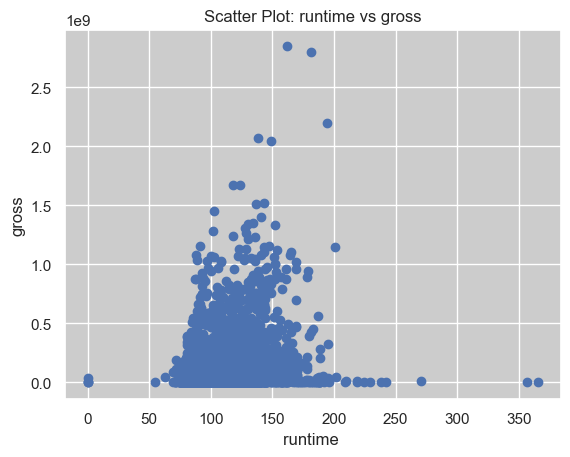

In [ ]:
plt.scatter(movies_metadata_df['runtime'], movies_metadata_df['gross'])
plt.xlabel('runtime ')
plt.ylabel('gross')
plt.title('Scatter Plot: runtime vs gross')
plt.show()

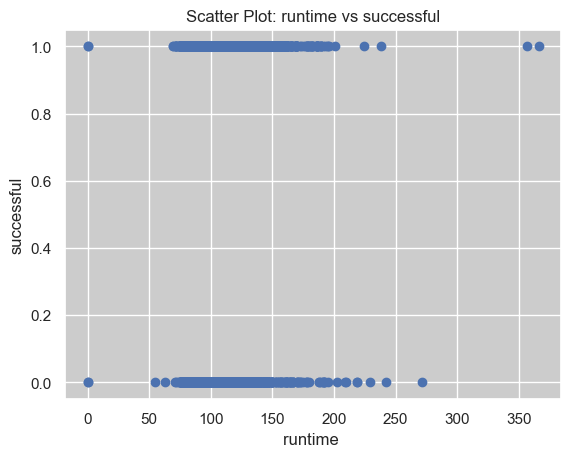

In [ ]:
plt.scatter(movies_metadata_df['runtime'], movies_metadata_df['successful'])
plt.xlabel('runtime ')
plt.ylabel('successful')
plt.title('Scatter Plot: runtime vs successful')
plt.show()

=> compare nó với revenue > 2*budget

### 2.5.13 Gross vs Successful

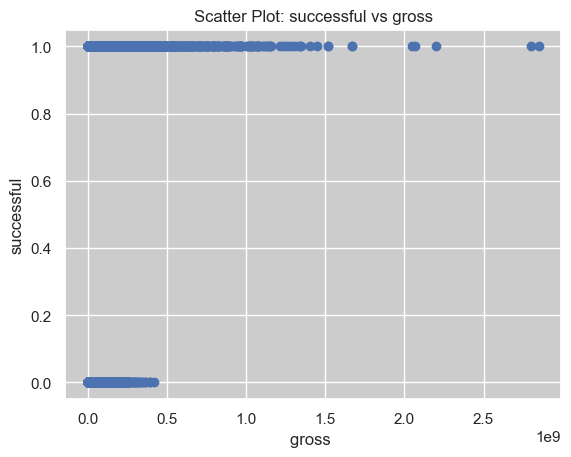

In [ ]:
plt.scatter(movies_metadata_df['gross'], movies_metadata_df['successful'])
plt.xlabel('gross ')
plt.ylabel('successful')
plt.title('Scatter Plot: successful vs gross')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming you have a DataFrame 'data'
categorical_features = ['genre','company', 'director', 'writer', 'star', 'country']

# Encode categorical features
encoder = LabelEncoder()
for feature in categorical_features:
  movies_metadata_df[f'{feature}_encoded'] = encoder.fit_transform(movies_metadata_df[feature])

In [ ]:
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Replace month names with corresponding numbers
movies_metadata_df['month_converted'] = movies_metadata_df['month'].replace(month_map)

In [ ]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['month'] != 'Unknown']

In [ ]:
movies_metadata_df['month_converted']

name
The Shining                                        6
The Blue Lagoon                                    7
Star Wars: Episode V - The Empire Strikes Back     6
Airplane!                                          7
Caddyshack                                         7
                                                  ..
More to Life                                      10
Dream Round                                        2
Saving Mbango                                      4
It's Just Us                                      10
Tee em el                                          8
Name: month_converted, Length: 7653, dtype: object

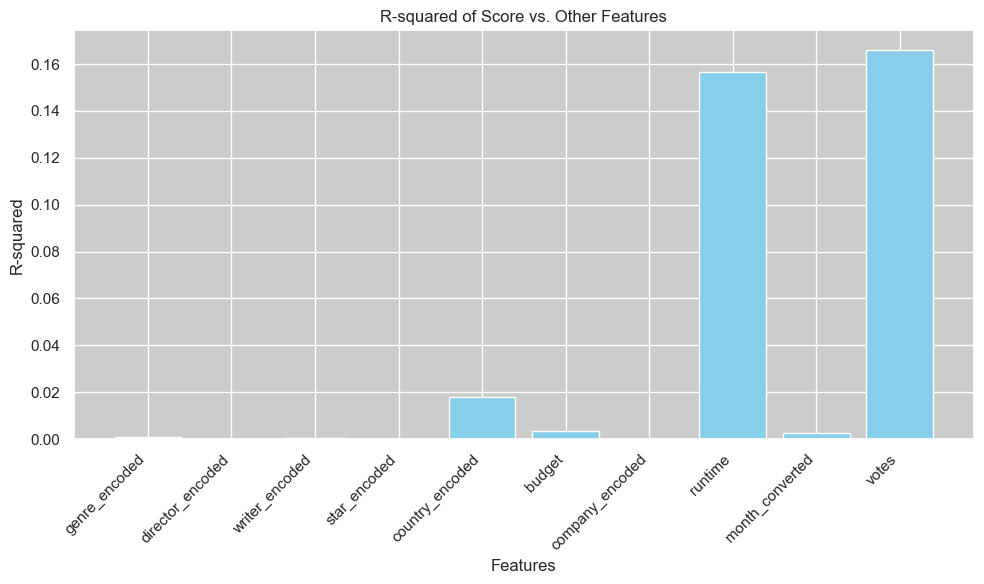

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Select score as the independent variable
X = movies_metadata_df[['score']]

# List of features to analyze (replace with your actual features)
features = ['genre_encoded', 'director_encoded',
       'writer_encoded', 'star_encoded', 'country_encoded', 'budget', 'company_encoded', 'runtime',
       'month_converted', 'votes']  # Include 'gross' for comparison

# Create an empty list to store R-squared values
r_squared_values = []

# Loop through features
for feature in features:
  y = movies_metadata_df[feature]  # Assign each feature as the dependent variable

  # Rest of the code for model creation, fitting, R-squared calculation
  model = LinearRegression()
  model.fit(X, y)
  predicted_y = model.predict(X)
  r_squared = r2_score(y, predicted_y)
  r_squared_values.append(r_squared)  # Store R-squared for each feature

# Bar chart creation
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(features, r_squared_values, color='skyblue')
plt.xlabel("Features")
plt.ylabel("R-squared")
plt.title("R-squared of Score vs. Other Features")
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.tight_layout()
plt.show()


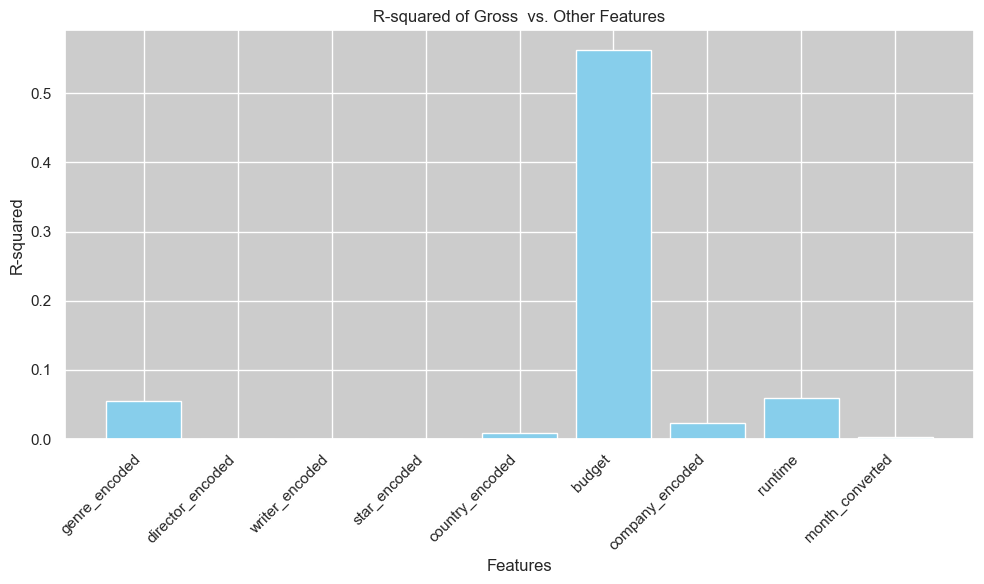

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Select score as the independent variable
X = movies_metadata_df[['gross']]

# List of features to analyze (replace with your actual features)
features = ['genre_encoded', 'director_encoded',
       'writer_encoded', 'star_encoded', 'country_encoded', 'budget', 'company_encoded', 'runtime',
       'month_converted']  # Include 'gross' for comparison

# Create an empty list to store R-squared values
r_squared_values = []

# Loop through features
for feature in features:
  y = movies_metadata_df[feature]  # Assign each feature as the dependent variable

  # Rest of the code for model creation, fitting, R-squared calculation
  model = LinearRegression()
  model.fit(X, y)
  predicted_y = model.predict(X)
  r_squared = r2_score(y, predicted_y)
  r_squared_values.append(r_squared)  # Store R-squared for each feature

# Bar chart creation
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(features, r_squared_values, color='skyblue')
plt.xlabel("Features")
plt.ylabel("R-squared")
plt.title("R-squared of Gross  vs. Other Features")
plt.xticks(rotation=45, ha='right')  # Rotate feature names for readability
plt.tight_layout()
plt.show()


In [ ]:
from numpy import corrcoef
correlation = corrcoef(X.T)

# Print the correlation matrix (optional)
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
1.0


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Select score and gross columns
X = movies_metadata_df[['score']]  # Independent variable (score)
y = movies_metadata_df['gross']    # Dependent variable (gross)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Make predictions (not needed for this analysis, but optional)
predicted_gross = model.predict(X)

# Get the coefficient of determination (R-squared)
r_squared = r2_score(y, predicted_gross)

# Get the p-value of the slope coefficient
p_value = model.coef_[0]  # Access the first coefficient (slope) p-value

# Print the results
print(f"R-squared: {r_squared:.4f}")
print(f"p-value of slope coefficient: {p_value:.4f}")
epsilon = 0.05
# Interpretation
if r_squared < epsilon and p_value > 0.05:
  print("This suggests score and gross might be independent variables.")
else:
  print("The results do not strongly support the independence of score and gross.")


R-squared: 0.0347
p-value of slope coefficient: 31300851.8428
This suggests score and gross might be independent variables.


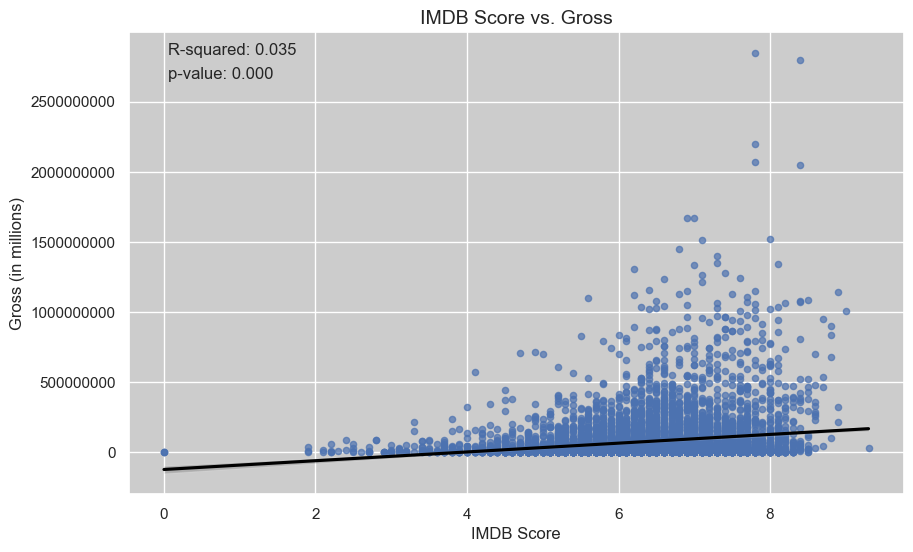

The results do not strongly support the independence of score and gross.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Linear Regression
X = movies_metadata_df[['score']]
y = movies_metadata_df['gross']
model = LinearRegression().fit(X, y)
predicted_gross = model.predict(X)

# Calculate metrics
r_squared = r2_score(y, predicted_gross)
slope, intercept, r_value, p_value, std_err = stats.linregress(movies_metadata_df['score'], movies_metadata_df['gross'])

# Create scatter plot with seaborn
sns.set_theme(style="darkgrid", rc={"axes.facecolor": ".8"})
plt.figure(figsize=(10, 6))
sns.regplot(x='score', y='gross', data=movies_metadata_df,
            scatter_kws={'s': 20, 'alpha': 0.7}, line_kws={'color': 'black'})

# Add labels and title
plt.xlabel('IMDB Score', fontsize=12)
plt.ylabel('Gross (in millions)', fontsize=12)
plt.title('IMDB Score vs. Gross', fontsize=14)

# Optionally add text annotations for R-squared and p-value directly on the plot
plt.text(0.05, 0.95, f"R-squared: {r_squared:.3f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f"p-value: {p_value:.3f}", transform=plt.gca().transAxes)
plt.ticklabel_format(style='plain', axis='y')
# Show the plot
plt.show()

# Interpretation
if r_squared < epsilon and p_value > 0.05:
  print("This suggests score and gross might be independent variables.")
else:
  print("The results do not strongly support the independence of score and gross.")


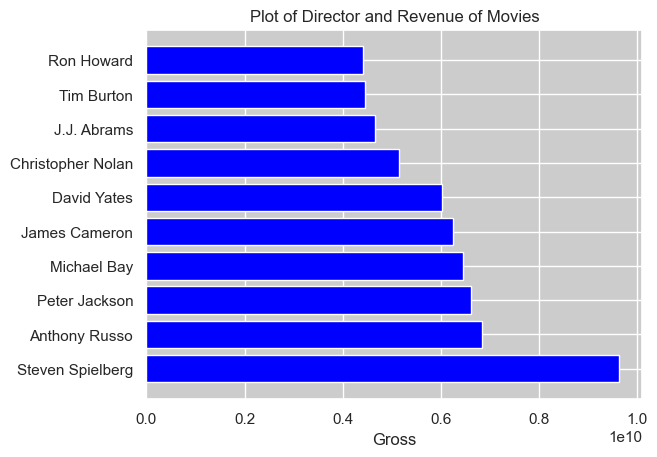

In [ ]:
# Group by 'Director' and sum 'Revenue'
grouped_df = movies_metadata_df.groupby('director')['gross'].sum().reset_index()

# Sort the DataFrame by 'Revenue' in descending order for better visualization
grouped_df = grouped_df.sort_values('gross', ascending=False).head(10)

# Create a horizontal bar plot
plt.barh(grouped_df['director'], grouped_df['gross'], color='blue')
plt.xlabel('Gross')
plt.title('Plot of Director and Revenue of Movies')
plt.show()

# 3. Baseline Model Building

## 3.1. Feature Engineering

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

**convert month to season**

In [ ]:
def convert_month_to_season(month):
    if month in [1, 2, 3]:
        return 'Spring'
    elif month in [4, 5, 6]:
        return 'Summer'
    elif month in [7, 8, 9]:
        return 'Fall'
    else:
        return 'Winter'
movies_metadata_df['season'] = movies_metadata_df['month'].apply(convert_month_to_season)

In [ ]:
movies_metadata_df['season']

name
The Shining                                       Winter
The Blue Lagoon                                   Winter
Star Wars: Episode V - The Empire Strikes Back    Winter
Airplane!                                         Winter
Caddyshack                                        Winter
                                                   ...  
More to Life                                      Winter
Dream Round                                       Winter
Saving Mbango                                     Winter
It's Just Us                                      Winter
Tee em el                                         Winter
Name: season, Length: 7653, dtype: object

**Convert runtime to Short, Medium, Long**

In [ ]:
def convert_runtime_to_bin(runtime):
    if runtime >= 0 and runtime < 90:
        return 'Short'
    elif runtime >= 90 and runtime < 120:
        return 'Medium'
    elif runtime >= 120:
        return 'Long'
movies_metadata_df['runtime_range'] = movies_metadata_df['runtime'].apply(convert_runtime_to_bin)

In [ ]:
movies_metadata_df['runtime_range']

name
The Shining                                         Long
The Blue Lagoon                                   Medium
Star Wars: Episode V - The Empire Strikes Back      Long
Airplane!                                          Short
Caddyshack                                        Medium
                                                   ...  
More to Life                                      Medium
Dream Round                                       Medium
Saving Mbango                                      Short
It's Just Us                                        Long
Tee em el                                         Medium
Name: runtime_range, Length: 7653, dtype: object

**Group rating to 5 main types: R, PG, G, PG-13, Unknown**

In [ ]:
def combine_rating(rating):
    if rating in ["R", "NC-17", "TV-MA"]:
        return 'R'
    elif rating in ["G", "Approved"]:
        return 'G'
    elif rating in ["PG-13", "TV-14"]:
        return 'PG-13'
    elif rating in ["PG", "TV-PG"]:
        return 'PG'
    else:
      return 'Unkown'
movies_metadata_df['rating_converted'] = movies_metadata_df['rating'].apply(combine_rating)

In [ ]:
movies_metadata_df['rating_converted'].unique()

array(['R', 'PG', 'G', 'Unkown', 'PG-13'], dtype=object)

In [ ]:
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

**Convert director to best_director**

In [ ]:
%cd /content/drive/MyDrive/Khai thác dữ liệu và ứng dụng - T5/Final_dataset/MoviesIndustry

[WinError 3] The system cannot find the path specified: '/content/drive/MyDrive/Khai thác dữ liệu và ứng dụng - T5/Final_dataset/MoviesIndustry'
d:\StreamlitDemo


In [ ]:
# Tính lợi nhuận cho mỗi bộ phim
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

# Tính tổng lợi nhuận cho mỗi đạo diễn
total_profit_by_director = movies_metadata_df.groupby('director')['profit'].sum()

# Tính các phần trăm phân vị
quantiles = total_profit_by_director.quantile([0.25, 0.5, 0.75])

# Tạo hàm tính điểm
def calculate_director_score(profit, quantiles):
    if profit > quantiles[0.75]:
        return 5
    elif profit > quantiles[0.5]:
        return 4
    elif profit > quantiles[0.25]:
        return 3
    elif profit > 0:
        return 1
    else:
        return 0

# Tạo cột mới 'director_score' dựa trên tổng lợi nhuận của mỗi đạo diễn
movies_metadata_df['director_total_profit'] = movies_metadata_df['director'].map(total_profit_by_director)
movies_metadata_df['director_score'] = movies_metadata_df['director_total_profit'].apply(lambda x: calculate_director_score(x, quantiles))

In [ ]:
movies_metadata_df['director_score'].unique()

array([5, 4, 0, 3, 1], dtype=int64)

In [ ]:
unique_director_df = movies_metadata_df[['director', 'director_score']].drop_duplicates()
print(unique_director_df.shape)

# Save the DataFrame to a CSV file
# unique_director_df.to_csv('data/director.csv', index=False)

(2943, 2)


In [ ]:
# Tính lợi nhuận cho mỗi bộ phim
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

total_profit_by_company = movies_metadata_df.groupby('company')['profit'].sum()

# Tính các phần trăm phân vị
quantiles = total_profit_by_company.quantile([0.25, 0.5, 0.75])

# Tạo hàm tính điểm
def calculate_company_score(profit, quantiles):
    if profit > quantiles[0.75]:
        return 5
    elif profit > quantiles[0.5]:
        return 4
    elif profit > quantiles[0.25]:
        return 3
    elif profit > 0:
        return 1
    else:
        return 0

movies_metadata_df['company_total_profit'] = movies_metadata_df['company'].map(total_profit_by_company)
movies_metadata_df['company_score'] = movies_metadata_df['company_total_profit'].apply(lambda x: calculate_company_score(x, quantiles))

In [ ]:
# Create a new DataFrame with unique 'company' and 'company_score' rows
unique_company_df = movies_metadata_df[['company', 'company_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
# unique_company_df.to_csv('data/company.csv', index=False)

(2376, 2)


In [ ]:
# Tính lợi nhuận cho mỗi bộ phim
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

total_profit_by_genre = movies_metadata_df.groupby('genre')['profit'].sum()

# Tính các phần trăm phân vị
quantiles = total_profit_by_genre.quantile([0.25, 0.5, 0.75])

# Tạo hàm tính điểm
def calculate_genre_score(profit, quantiles):
    if profit > quantiles[0.75]:
        return 5
    elif profit > quantiles[0.5]:
        return 4
    elif profit > quantiles[0.25]:
        return 3
    elif profit > 0:
        return 1
    else:
        return 0

movies_metadata_df['genre_total_profit'] = movies_metadata_df['genre'].map(total_profit_by_genre)
movies_metadata_df['genre_score'] = movies_metadata_df['genre_total_profit'].apply(lambda x: calculate_genre_score(x, quantiles))

In [ ]:
# Create a new DataFrame with unique 'genre' and 'genre_score' rows
unique_genre_df = movies_metadata_df[['genre', 'genre_score']].drop_duplicates()
print(unique_genre_df.shape)

# Save the DataFrame to a CSV file
# unique_genre_df.to_csv('data/genre.csv', index=False)

(19, 2)


In [ ]:
# Tính lợi nhuận cho mỗi bộ phim
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

total_profit_by_star = movies_metadata_df.groupby('star')['profit'].sum()

# Tính các phần trăm phân vị
quantiles = total_profit_by_star.quantile([0.25, 0.5, 0.75])

# Tạo hàm tính điểm
def calculate_star_score(profit, quantiles):
    if profit > quantiles[0.75]:
        return 5
    elif profit > quantiles[0.5]:
        return 4
    elif profit > quantiles[0.25]:
        return 3
    elif profit > 0:
        return 1
    else:
        return 0

movies_metadata_df['star_total_profit'] = movies_metadata_df['star'].map(total_profit_by_star)
movies_metadata_df['star_score'] = movies_metadata_df['star_total_profit'].apply(lambda x: calculate_star_score(x, quantiles))

In [ ]:
# Create a new DataFrame with unique 'start' and 'start_score' rows
unique_start_df = movies_metadata_df[['star', 'star_score']].drop_duplicates()
print(unique_start_df.shape)

# Save the DataFrame to a CSV file
# unique_start_df.to_csv('data/star.csv', index=False)

(2808, 2)


In [ ]:
# Tính lợi nhuận cho mỗi bộ phim
movies_metadata_df['profit'] = movies_metadata_df['gross'] - movies_metadata_df['budget']

total_profit_by_writer = movies_metadata_df.groupby('writer')['profit'].sum()

# Tính các phần trăm phân vị
quantiles = total_profit_by_writer.quantile([0.25, 0.5, 0.75])

# Tạo hàm tính điểm
def calculate_writer_score(profit, quantiles):
    if profit > quantiles[0.75]:
        return 5
    elif profit > quantiles[0.5]:
        return 4
    elif profit > quantiles[0.25]:
        return 3
    elif profit > 0:
        return 1
    else:
        return 0

movies_metadata_df['writer_total_profit'] = movies_metadata_df['writer'].map(total_profit_by_writer)
movies_metadata_df['writer_score'] = movies_metadata_df['writer_total_profit'].apply(lambda x: calculate_writer_score(x, quantiles))

In [ ]:
# Create a new DataFrame with unique 'writer' and 'writer_score' rows
unique_company_df = movies_metadata_df[['writer', 'writer_score']].drop_duplicates()
print(unique_company_df.shape)

# Save the DataFrame to a CSV file
# unique_company_df.to_csv('data/writer.csv', index=False)

(4530, 2)


## 3.2. Creating the Model

As mentioned before, the chosen model for the baseline will be the classic Linear Regression, next are the train/test split, model building, predicting using the model, and model evaluation.

In [ ]:
movies_metadata_df.columns

Index(['rating', 'genre', 'year', 'released', 'score', 'votes', 'director',
       'writer', 'star', 'country', 'budget', 'gross', 'company', 'runtime',
       'month', 'successful', 'condition_1', 'genre_encoded',
       'company_encoded', 'director_encoded', 'writer_encoded', 'star_encoded',
       'country_encoded', 'month_converted', 'season', 'runtime_range',
       'rating_converted', 'profit', 'director_total_profit', 'director_score',
       'company_total_profit', 'company_score', 'genre_total_profit',
       'genre_score', 'star_total_profit', 'star_score', 'writer_total_profit',
       'writer_score'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and 'category' is the column with categorical data
le = LabelEncoder()
movies_metadata_df['director'] = le.fit_transform(movies_metadata_df['director'])
movies_metadata_df['genre'] = le.fit_transform(movies_metadata_df['genre'])
movies_metadata_df['company'] = le.fit_transform(movies_metadata_df['company'])
movies_metadata_df['star'] = le.fit_transform(movies_metadata_df['star'])
movies_metadata_df['writer'] = le.fit_transform(movies_metadata_df['writer'])
movies_metadata_df['country'] = le.fit_transform(movies_metadata_df['country'])
movies_metadata_df['rating'] = le.fit_transform(movies_metadata_df['rating'])
movies_metadata_df['released'] = le.fit_transform(movies_metadata_df['released'])
movies_metadata_df['rating'] = le.fit_transform(movies_metadata_df['rating'])
movies_metadata_df['season'] = le.fit_transform(movies_metadata_df['season'])

In [ ]:
movies_metadata_df['rating_converted'] = le.fit_transform(movies_metadata_df['rating_converted'])

In [ ]:
unknown_count = movies_metadata_df['month'].value_counts().get('Unknown', 0)
print(f"Number of 'Unknown' month values: {unknown_count}")

Number of 'Unknown' month values: 0


In [ ]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['month'] != 'Unknown']

In [ ]:
month_map = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Replace month names with corresponding numbers
movies_metadata_df['month_converted'] = movies_metadata_df['month'].replace(month_map)

### 3.2.1 Linear Regrssion

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pickle

In [ ]:
# Split the data into training and testing sets
X = movies_metadata_df[['budget', 'runtime', 'rating_converted', 'director_score', 'company_score', 'genre_score', 'star_score', 'writer_score', 'month_converted']]
y = movies_metadata_df['profit']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict using the model
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

Mean absolute error: 52546373.936002344


In [ ]:
# Perform grid search for Linear Regression
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
    'n_jobs': [None]
}
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Predict using the best model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

Best parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': True}
Mean absolute error: 52478397.0839906


In [ ]:
# Save the best model
# with open('model/LinearRegression.sav', 'wb') as lr_model_file:
#     pickle.dump(best_model, lr_model_file)

### 3.2.1 Decision Tree

**Decision Tree without Data Insight**

In [ ]:
# Split the data into training and testing sets

X = movies_metadata_df[['rating', 'genre','year', 'released',  'writer', 'star', 'country', 'budget', 'company', 'runtime']]
y = movies_metadata_df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# finding best parameter for Decision Tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import numpy as np
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate accuracy
accuracy = np.mean(y_pred_binary == y_test)
print("Accuracy:", accuracy)


Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'random_state': 42, 'splitter': 'best'}
Mean absolute error: 0.27433050293925537
Accuracy: 0.7256694970607446


In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred_binary))

Confusion Matrix :
[[372 202]
 [218 739]]

Classification Report :
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       574
           1       0.79      0.77      0.78       957

    accuracy                           0.73      1531
   macro avg       0.71      0.71      0.71      1531
weighted avg       0.73      0.73      0.73      1531



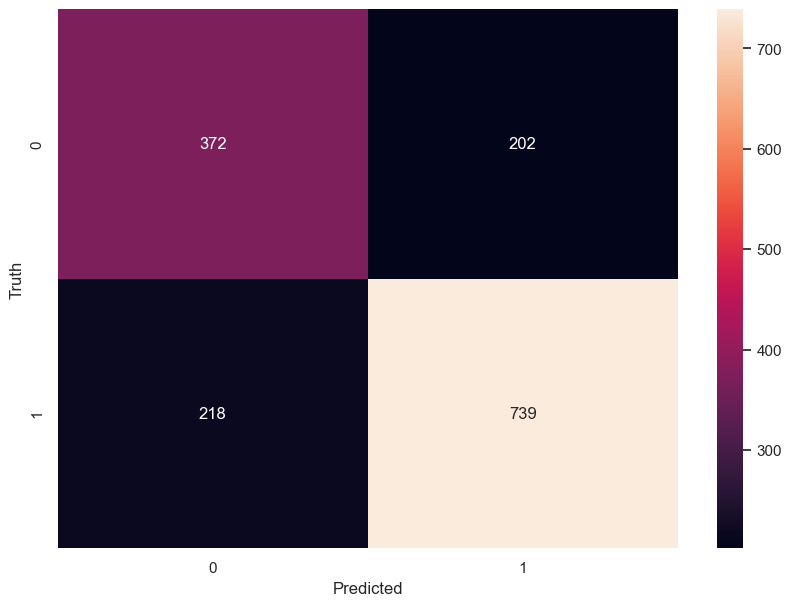

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**Pre-prunning with data insights**

In [ ]:
X = movies_metadata_df[['budget', 'runtime','rating_converted', 'director_score', 'company_score','genre_score', 'star_score', 'writer_score', 'month_converted']]
y = movies_metadata_df['successful']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Finding the best parameters for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)

# Evaluate the best model
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'random_state': 42, 'splitter': 'best'}
Mean absolute error: 0.124101894186806
Accuracy: 0.8758981058131939


In [ ]:
# Tạo bản sao của X_test và y_test
test_samples = X_test.copy()
test_samples['actual'] = y_test
test_samples['predicted'] = y_pred

# Danh sách các tiêu đề cần chọn (sử dụng chỉ mục)
titles_to_select = ['Annihilation', 'American Wedding', 'Faraway, So Close!', 'Hero']

# Lọc các mẫu dựa trên chỉ mục
selected_samples = test_samples.loc[titles_to_select]

# Hiển thị kết quả
selected_samples


,budget,runtime,rating_converted,director_score,company_score,genre_score,star_score,writer_score,month_converted,actual,predicted
name,,,,,,,,,,,
Annihilation,40000000.0,115.0,3,4,5,5,5,5,2,0,1
American Wedding,55000000.0,96.0,3,5,5,5,5,5,8,1,1
"Faraway, So Close!",10500000.0,140.0,2,0,0,5,0,5,12,0,0
Hero,31000000.0,120.0,2,5,5,5,5,5,8,1,1


In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[441 133]
 [ 57 900]]

Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       574
           1       0.87      0.94      0.90       957

    accuracy                           0.88      1531
   macro avg       0.88      0.85      0.86      1531
weighted avg       0.88      0.88      0.87      1531



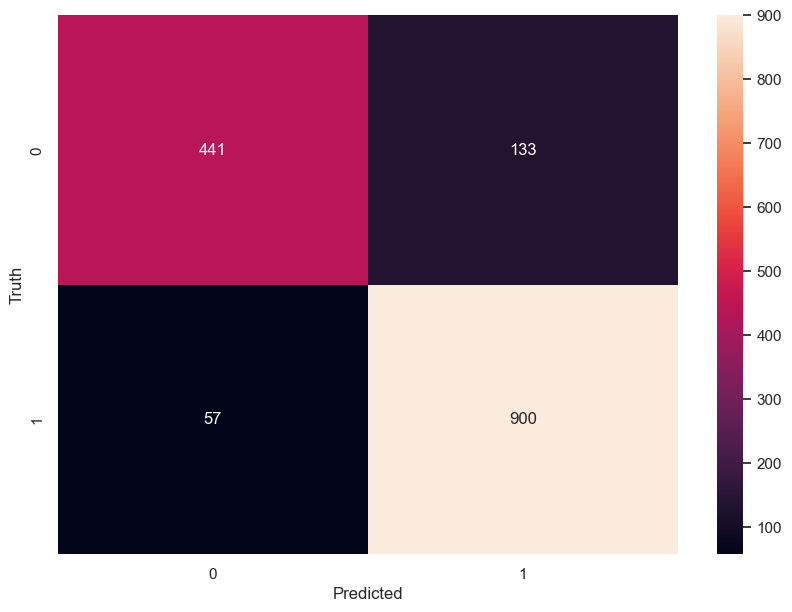

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
# Save the best model
# with open('model/PreDecisionTree.sav', 'wb') as model_file:
#     pickle.dump(best_model, model_file)

**PostPruning**

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

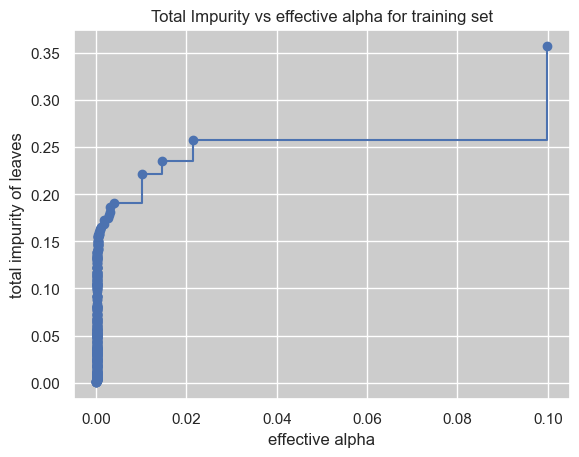

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.11569130770977226


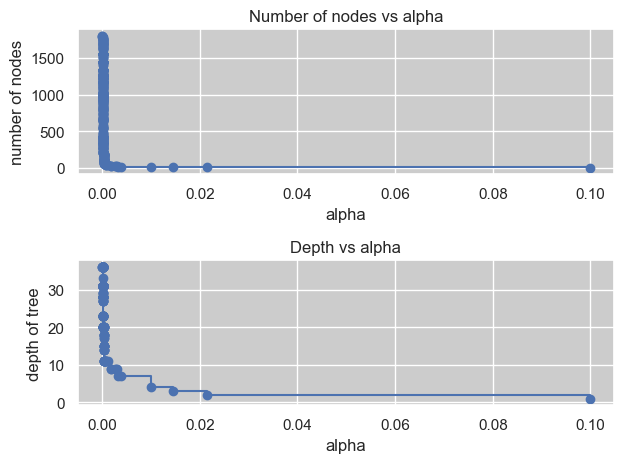

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


In [ ]:
print("Columns in X_train: ", X_train.columns)
print("Columns in X_test: ", X_test.columns)

Columns in X_train:  Index(['budget', 'runtime', 'rating_converted', 'director_score',
       'company_score', 'genre_score', 'star_score', 'writer_score',
       'month_converted'],
      dtype='object')
Columns in X_test:  Index(['budget', 'runtime', 'rating_converted', 'director_score',
       'company_score', 'genre_score', 'star_score', 'writer_score',
       'month_converted'],
      dtype='object')


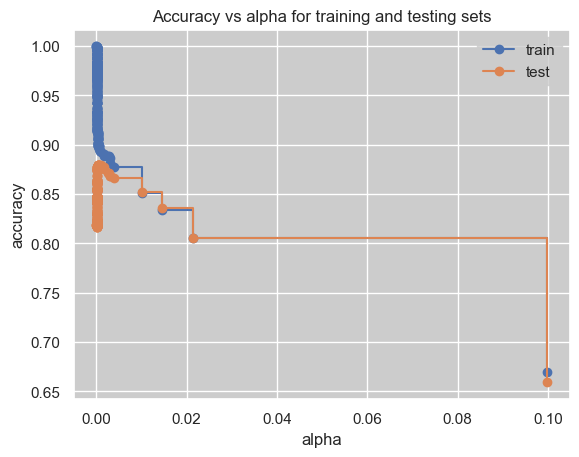

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

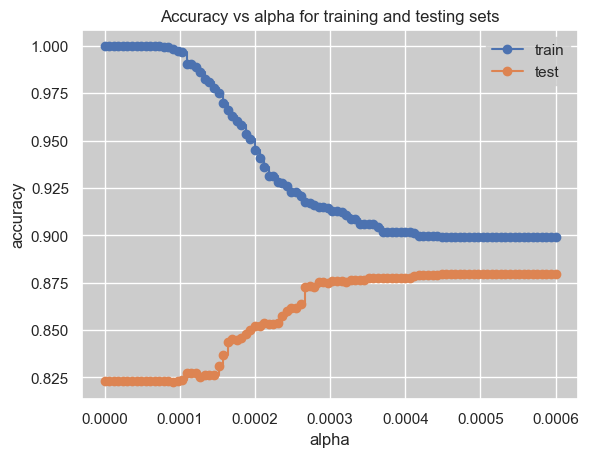

In [ ]:
import numpy as np

# Assuming your current range of ccp_alphas is from min_alpha to max_alpha
min_alpha = min(ccp_alphas)
max_alpha = 0.0006

# Create a more finely spaced range of alphas
fine_ccp_alphas = np.linspace(min_alpha, max_alpha, num=100)  # Change num to the number of bins you want

# Now you need to retrain your models with these new alphas and get the scores
fine_clfs = [DecisionTreeClassifier(random_state=0, ccp_alpha=alpha).fit(X_train, y_train) for alpha in fine_ccp_alphas]
fine_train_scores = [clf.score(X_train, y_train) for clf in fine_clfs]
fine_test_scores = [clf.score(X_test, y_test) for clf in fine_clfs]

# And plot the results
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(fine_ccp_alphas, fine_train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(fine_ccp_alphas, fine_test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(ccp_alpha=0.0004)

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
rounded_accuracy = round(accuracy, 2)
print(accuracy)

0.8772044415414761


In [ ]:
# Print the parameters
print(f"class_weight: {model.class_weight}")
print(f"criterion: {model.criterion}")
print(f"max_depth: {model.max_depth}")
print(f"min_samples_leaf: {model.min_samples_leaf}")
print(f"min_samples_split: {model.min_samples_split}")
print(f"random_state: {model.random_state}")
print(f"splitter: {model.splitter}")

class_weight: None
criterion: gini
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
random_state: None
splitter: best


In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix :')
print(cm)

# Print the classification report
print('\nClassification Report :')
print(classification_report(y_test, y_pred))

Confusion Matrix :
[[444 130]
 [ 58 899]]

Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.77      0.83       574
           1       0.87      0.94      0.91       957

    accuracy                           0.88      1531
   macro avg       0.88      0.86      0.87      1531
weighted avg       0.88      0.88      0.88      1531



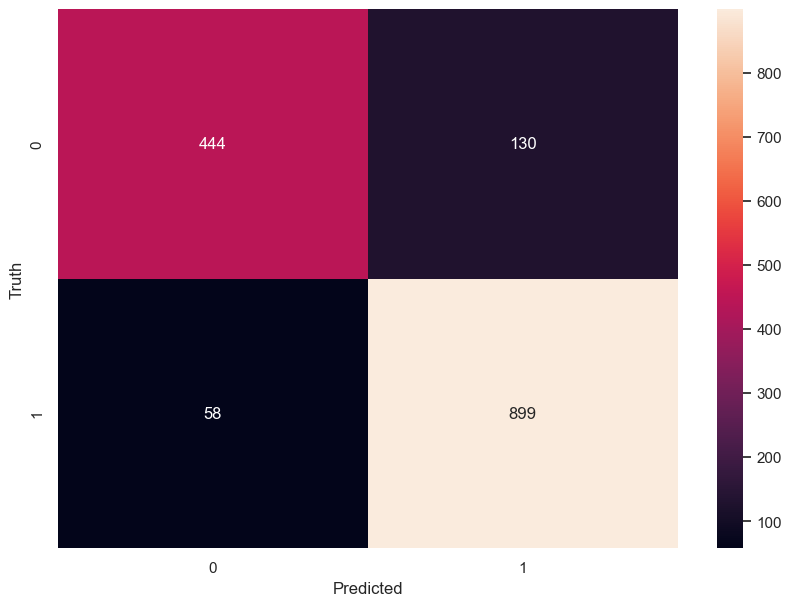

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error:", mae)

Mean absolute error: 0.12279555845852384


In [ ]:
# Save the best model
# with open('model/PostDecisionTree.sav', 'wb') as model_file:
#     pickle.dump(best_model, model_file)

**Tree**

In [ ]:
model.max_depth

In [ ]:
X.columns

Index(['budget', 'runtime', 'rating_converted', 'director_score',
       'company_score', 'genre_score', 'star_score', 'writer_score',
       'month_converted'],
      dtype='object')

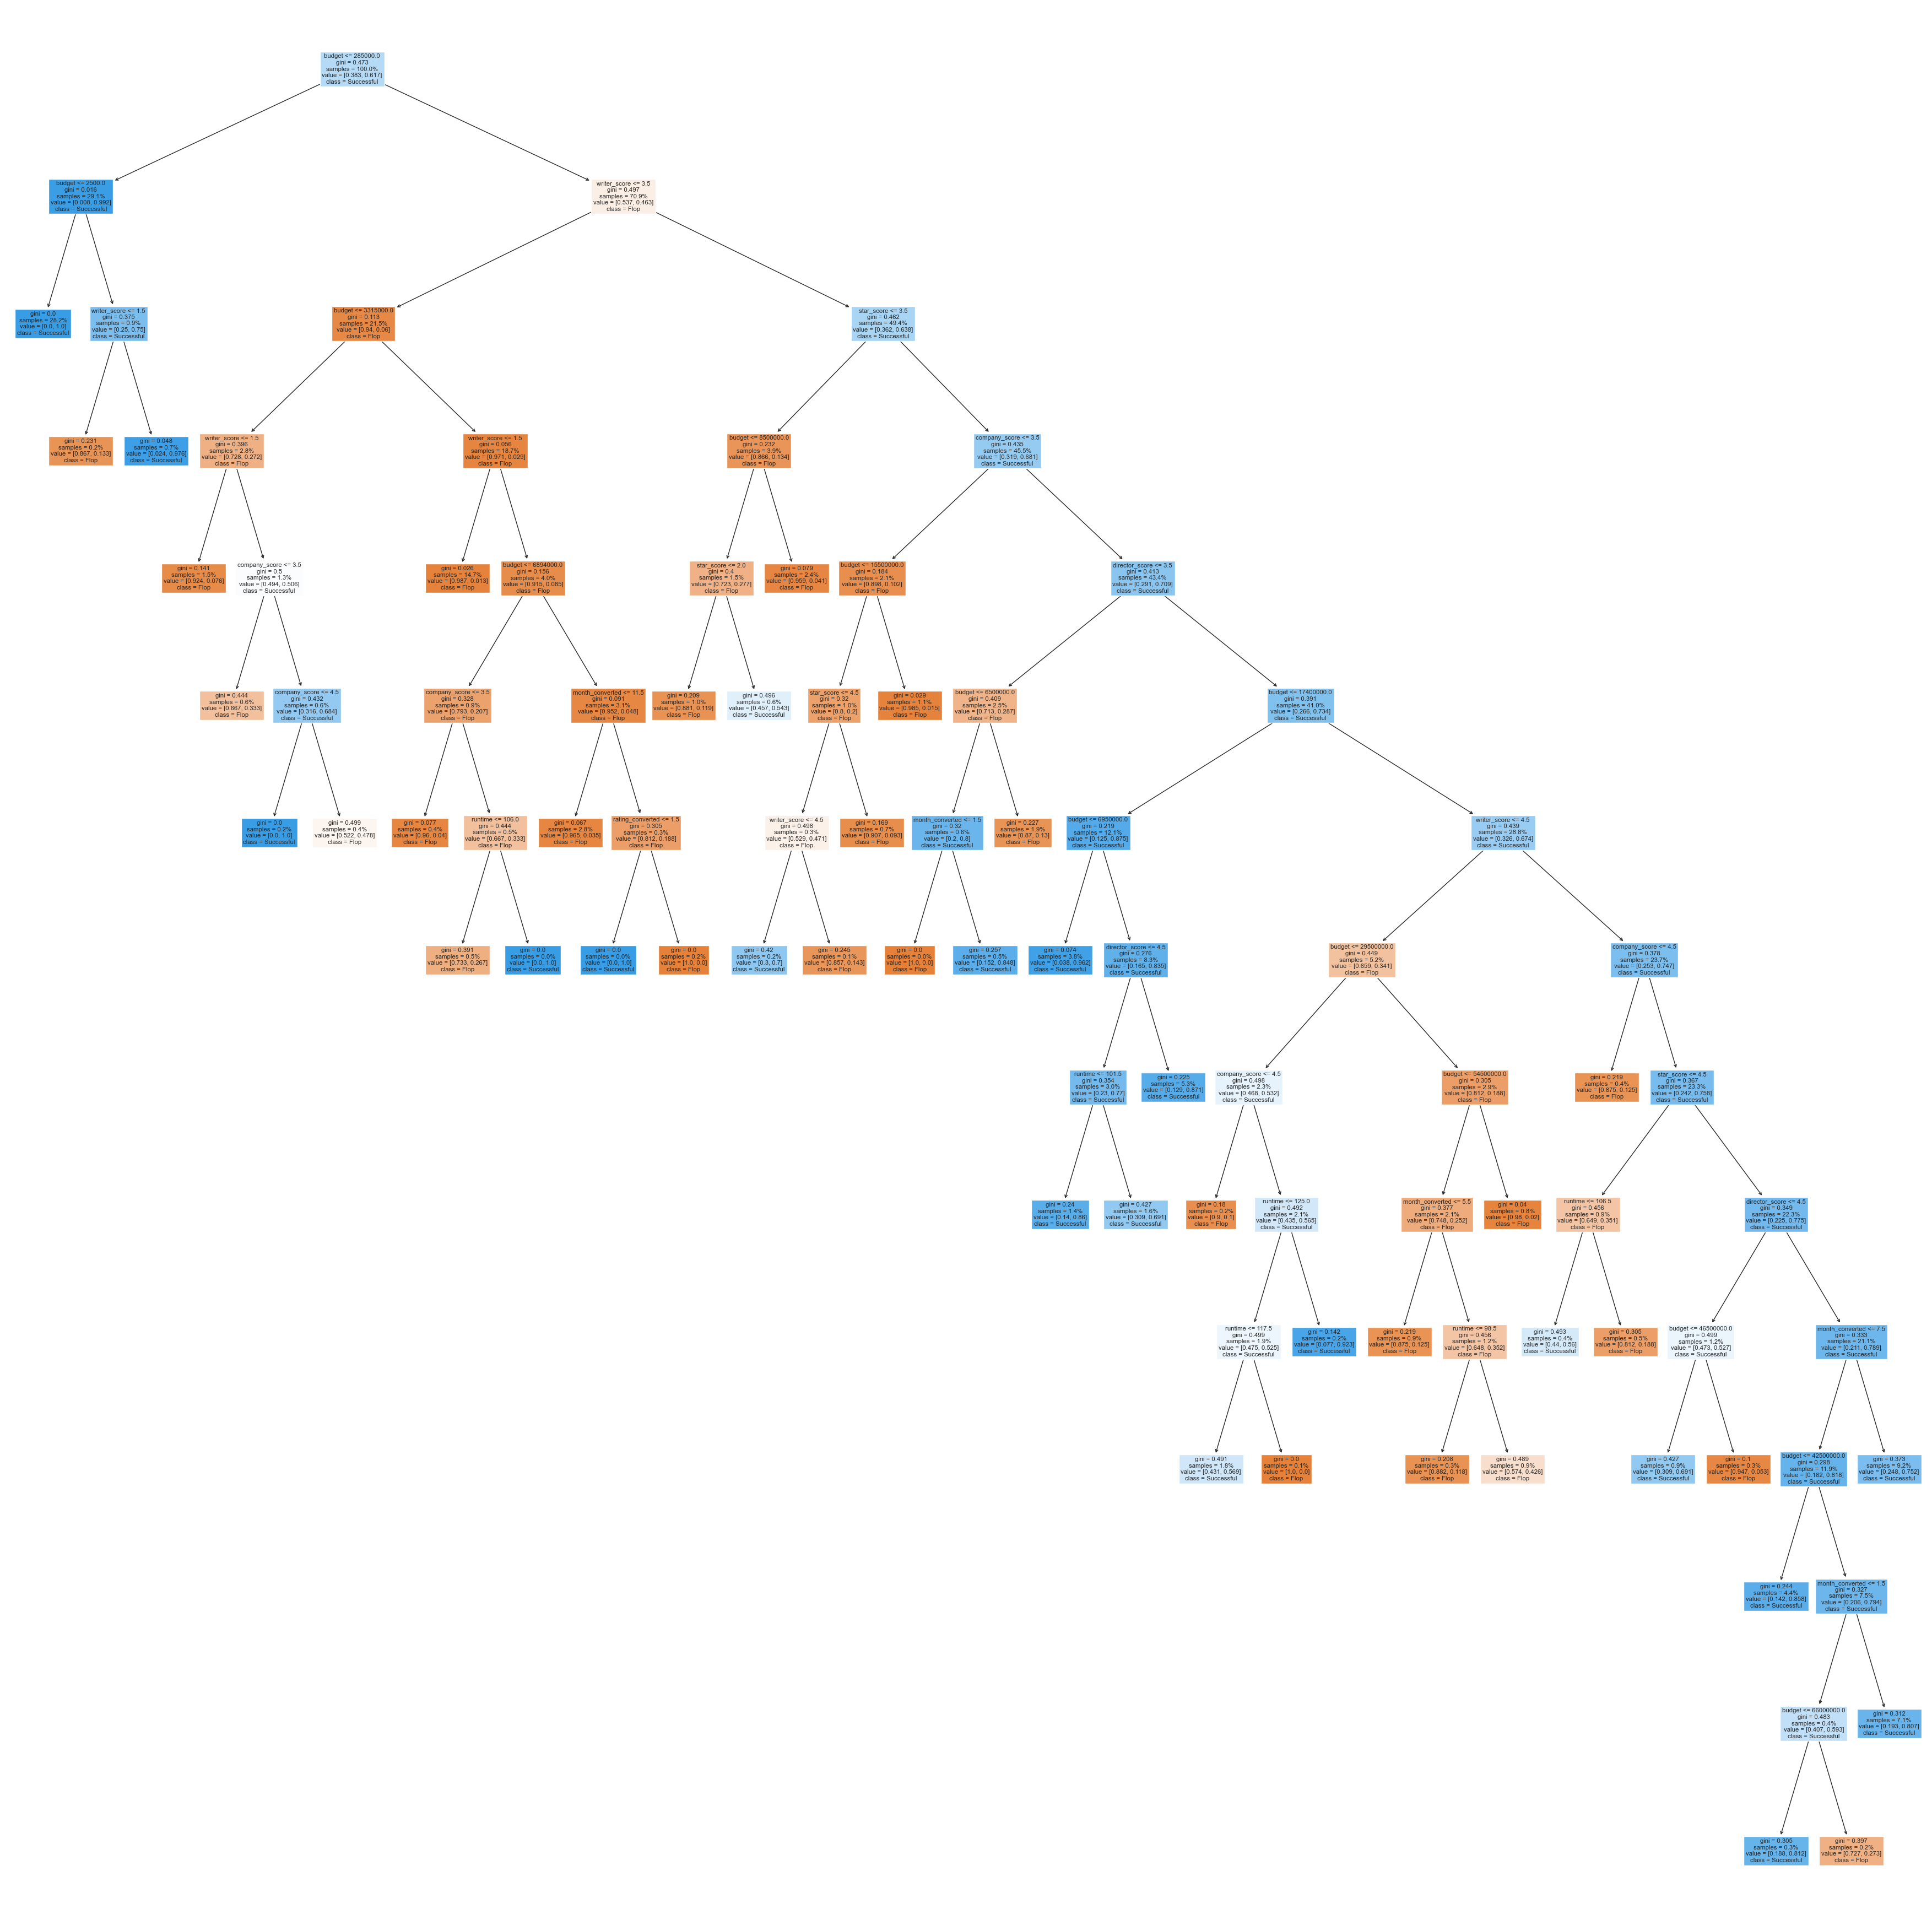

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained Decision Tree model
plt.figure(figsize=(45, 45))
plot_tree(model, filled=True, feature_names=X_train.columns, class_names=['Flop', 'Successful'], proportion=True)
# plt.savefig('decision_tree.png')
plt.show()


**XGBoost**

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
param_grid = {
    'max_depth': range(2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

# Create a XGBClassifier object
xgb = XGBClassifier(objective='binary:logistic', nthread=4, seed=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', n_jobs=10, cv=10, verbose=True)

# Fit the GridSearchCV object to your data (replace X and Y with your data)
grid_search.fit(X, y)

# Print the best parameters
print(grid_search.best_params_)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 180}


In [ ]:
from sklearn.metrics import accuracy_score

# Get the best parameters
best_params = grid_search.best_params_

# Create a new XGBClassifier with the best parameters
xgb_best = XGBClassifier(**best_params)

# Split your data into training and test sets
# (replace X, Y with your data and test_size with the desired test set size)
from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Fit the classifier to the training data
xgb_best.fit(X_train, y_train)

# Make predictions on the test set
Y_pred = xgb_best.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f'Accuracy: {accuracy}')

Accuracy: 0.8772044415414761
